
# TIME SERIES - PORT CITY SIMULATION DATA (CNR)

## Introduction


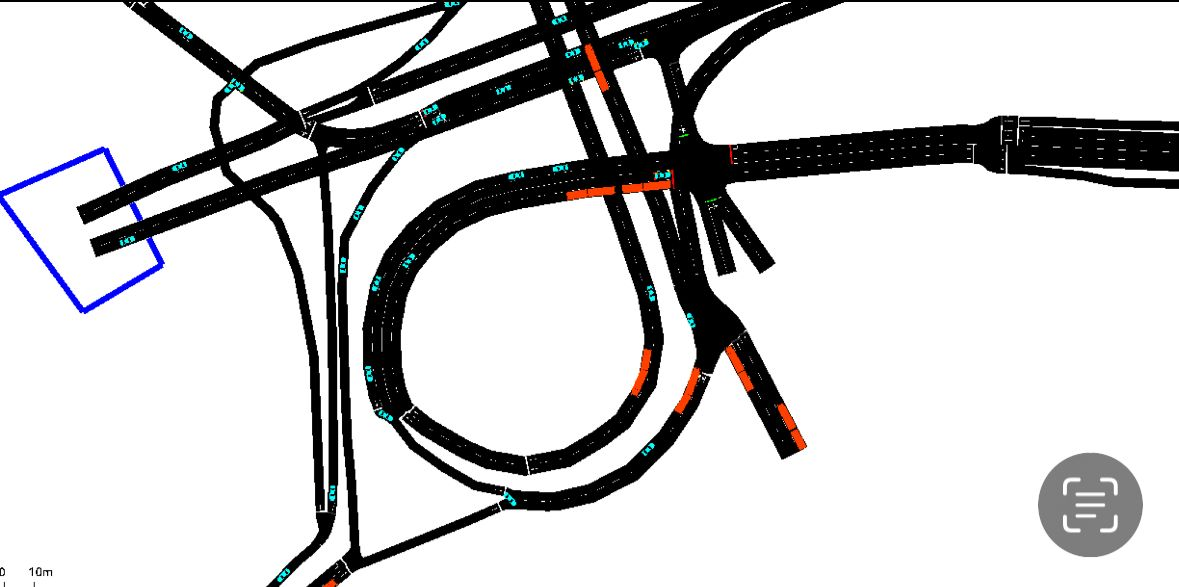


### **Purpose:**
Two pickle files contain data from simulations modeling traffic under two scenarios:
- **Scenario 0:** Standard traffic conditions.
- **Scenario 1:** One port gate is closed, forcing trucks to reroute.

### **Simulation Details:**
- **Runs:** 200 simulations, each lasting 1 hour.
- **Time Frames:** Data is aggregated into 12 time blocks (5 minutes each).
- **Network:** Includes 85 segments (edges).
- **Traffic:** Origin/destination flows of 25 sources (cars and trucks) are drawn from Gaussian distributions.

### **Variables in the Data:**
- **speed_all, speed_cars, speed_trucks:** Average speed on all edges for all vehicles, cars, and trucks respectively.
- **num_cars, num_trucks:** Average number of cars and trucks on all edges.
- **flow_cars, flow_trucks:** Average flow (vehicles reaching the end of edges) for cars and trucks.
- **inflows:** Input origin/destination traffic, reflecting policy changes.

**Segments of Interest**

The points identified are locations with the **highest interactions of car and truck flows**. These are expected to be most impacted by policy changes. The points are as follows:

#### 1. Lungomare Canepa (Eastbound)
- **Description**: Gathers traffic from trucks and cars moving west towards the Genova Ovest highway booth, and the east part of the city.  
- **Additional Traffic**: Includes trucks coming from the Etiopia Gate.

#### 2. Via di Francia (Eastbound)
- **Description**: Often congested, especially during heavy ferry traffic.

#### 3. Elicoidale "Downstream"
- **Location**: Part of the Elicoidale roundabout near the Genova Ovest highway booth.  
- **Description**: Collects trucks from the highway and mobility traffic.

#### 4. Elicoidale "Upstream"
- **Location**: Another portion of the Elicoidale roundabout, handling trucks coming from the San Benigno Gate.  
- **Description**: Routes traffic towards the Genova Ovest highway booth and mobility traffic.

---

### Corresponding Data Indices

In the data provided, these points correspond to the following indices in the matrices (range: 0–84 in Python style):

| **Point**            | **Index** |
|-----------------------|-----------|
| Lungomare Canepa     | 43        |
| Via di Francia        | 70        |
| Elicoidale "Downstream" | 6       |
| Elicoidale "Upstream" | 62        |

---

### Additional Notes

- **Initial Selection**: These points were chosen **a priori**, based on expected behavior.  
- **Further Adjustments**: Modifications might be needed as insights are derived from the analysis.  
- **Starting Point**: These locations provide a solid foundation for the analysis.

## Import Dependencies & Pickle Files





In [1]:
import pickle
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
import seaborn as sns

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# path_scenario_0 = 'data_scenario0.pkl'
# path_scenario_1 = 'data_scenario1.pkl'
path_scenario_0 = '/content/drive/MyDrive/TESE/data/data_scenario0.pkl'
path_scenario_1 = '/content/drive/MyDrive/TESE/data/data_scenario1.pkl'
path_scenario_0_new = '/content/drive/MyDrive/TESE/data/data_scenario0_new.pkl'
path_scenario_1_new = '/content/drive/MyDrive/TESE/data/data_scenario1_new.pkl'


def import_pickle(path):
  if os.path.exists(path):
    with open(path, 'rb') as f:
      print("Pickle file imported from: ", path)
      return pickle.load(f)
  else:
    print("File not found.")

data_scenario_0 = import_pickle(path_scenario_0_new)
data_scenario_1 = import_pickle(path_scenario_1_new)

Pickle file imported from:  /content/drive/MyDrive/TESE/data/data_scenario0_new.pkl
Pickle file imported from:  /content/drive/MyDrive/TESE/data/data_scenario1_new.pkl


## Explore data variable shapes

In [4]:
def show_shapes(data):
  for key, value in data.items():
    print(f"Variable: {key}")
    print(data[f'{key}'].shape)
    print(type(data[f'{key}']))
    print("-" * 20)

print("SCENARIO 0 \n")
show_shapes(data_scenario_0)
print("\n\n")
print("SCENARIO 1 \n")
show_shapes(data_scenario_1)

SCENARIO 0 

Variable: speed_all
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: flow_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: flow_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: inflows
(1000, 25)
<class 'numpy.ndarray'>
--------------------



SCENARIO 1 

Variable: speed_all
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: speed_trucks
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable: num_cars
(1000, 85, 12)
<class 'numpy.ndarray'>
--------------------
Variable

## Define variables

In [5]:
# Define the road segment k
interesting_k = [6, 43, 62, 70]

segments_k = {
    "Elicoidale Downstream": 6,
    "Lungomare Canepa": 43,
    "Elicoidale Upstream": 62,
    "Via di Francia": 70
}

def get_key_by_value(dictionary, value):
    for key, val in dictionary.items():
        if val == value:
            return key
    return None


# Number of time chunks
num_time_chunks = 12

# Define the list of variables and their names
variables_s0 = [data_scenario_0['speed_cars'],data_scenario_0['speed_trucks'],
                data_scenario_0['num_cars'], data_scenario_0['num_trucks'],
                data_scenario_0['flow_cars'], data_scenario_0['flow_trucks']]

variables_s1 = [data_scenario_1['speed_cars'],data_scenario_1['speed_trucks'],
                data_scenario_1['num_cars'], data_scenario_1['num_trucks'],
                data_scenario_1['flow_cars'], data_scenario_1['flow_trucks']]

variable_names = ["Speed Cars", "Speed Trucks", "Number of Cars", "Number of Trucks", "Flow Cars", "Flow Trucks"]

aggregation_types = {
    "Speed Cars": "mean",
    "Speed Trucks": "mean",
    "Number of Cars": "mean",
    "Number of Trucks": "mean",
    "Flow Cars": "sum",
    "Flow Trucks": "sum"
}

timechunk_step = 1

index_segments_k = {
    "Lungomare Canepa": 1,
    "Via di Francia": 3,
    "Elicoidale Downstream": 0,
    "Elicoidale Upstream": 2
}

batch_sizes = [8, 16, 32, 64, 100]

# Number of variables
num_variables = len(variable_names)

# Placeholder for W (can vary)
# W is the number of points we put in the batch from per day
W = 1

## Reaggregate Variables in Multivariate Time Series format

The idea here is to have the TS data as a np.ndarray with shape (number_of_interesting_k * num_variables, n, t), where n is the amount of simulation runs and t is the amount of timechunks

In [6]:
# Helper function to reshuffle indices
def get_shuffled_indices(N, B):
    indices = np.random.choice(np.arange(N), size=N, replace=False)
    return indices[:B], indices[B:2*B]  # Return two non-overlapping subsets

In [7]:
def reaggregate_variables(data, interesting_k, variable_list):
    num_runs, num_segments, num_time_chunks = variable_list[0].shape  # Assumes all variable shapes are equal
    num_interesting_k = len(interesting_k)
    num_variables = len(variable_list)

    # Changed the shape of reaggregated_data to (number_of_interesting_k * num_variables, n, t)
    reaggregated_data = np.zeros((num_interesting_k * num_variables, num_runs, num_time_chunks))

    for i, k in enumerate(interesting_k):
        for j, variable in enumerate(variable_list):
            # Now assigning data for each segment k across all simulation runs and time chunks
            reaggregated_data[i * num_variables + j, :, :] = variable[:, k, :]
    return reaggregated_data


In [8]:
# Scenario 0:
reaggregated_s0 = reaggregate_variables(data_scenario_0, interesting_k, variables_s0)
print(reaggregated_s0.shape)

# Scenario 1:
reaggregated_s1 = reaggregate_variables(data_scenario_1, interesting_k, variables_s1)
reaggregated_s1.shape

(24, 1000, 12)


(24, 1000, 12)

In [9]:
def aggregate_timechunks(data, timechunk_step, aggregation_types):
    """
    Aggregates time chunks in a NumPy array based on specified steps and aggregation types.

    Args:
        data (np.ndarray): The input data with shape (num_variables, num_runs, num_time_chunks).
        timechunk_step (int): The number of time chunks to aggregate into one.
        aggregation_types (dict): A dictionary where keys are variable names and values are aggregation types ('mean' or 'sum').

    Returns:
        np.ndarray: The aggregated data.
    """

    num_variables, num_runs, num_time_chunks = data.shape
    new_num_time_chunks = num_time_chunks // timechunk_step

    aggregated_data = np.zeros((num_variables, num_runs, new_num_time_chunks))

    for var_idx in range(num_variables):
        # The modulo operator (%) ensures the index wraps around to stay within the range of variable_names
        var_name_idx = var_idx % len(variable_names) # This is the key change
        for run_idx in range(num_runs):
            for new_chunk_idx in range(new_num_time_chunks):
                start_idx = new_chunk_idx * timechunk_step
                end_idx = (new_chunk_idx + 1) * timechunk_step
                chunk = data[var_idx, run_idx, start_idx:end_idx]

                if aggregation_types[variable_names[var_name_idx]].lower() == 'mean': # Using var_name_idx here
                    aggregated_data[var_idx, run_idx, new_chunk_idx] = np.mean(chunk)
                elif aggregation_types[variable_names[var_name_idx]].lower() == 'sum': # Using var_name_idx here
                    aggregated_data[var_idx, run_idx, new_chunk_idx] = np.sum(chunk)
                else:
                    raise ValueError(f"Invalid aggregation type: {aggregation_types[variable_names[var_idx]]}")

    return aggregated_data


aggregated_s0 = aggregate_timechunks(reaggregated_s0, timechunk_step, aggregation_types)
print(aggregated_s0.shape)

aggregated_s1 = aggregate_timechunks(reaggregated_s1, timechunk_step, aggregation_types)
print(aggregated_s1.shape)

(24, 1000, 12)
(24, 1000, 12)


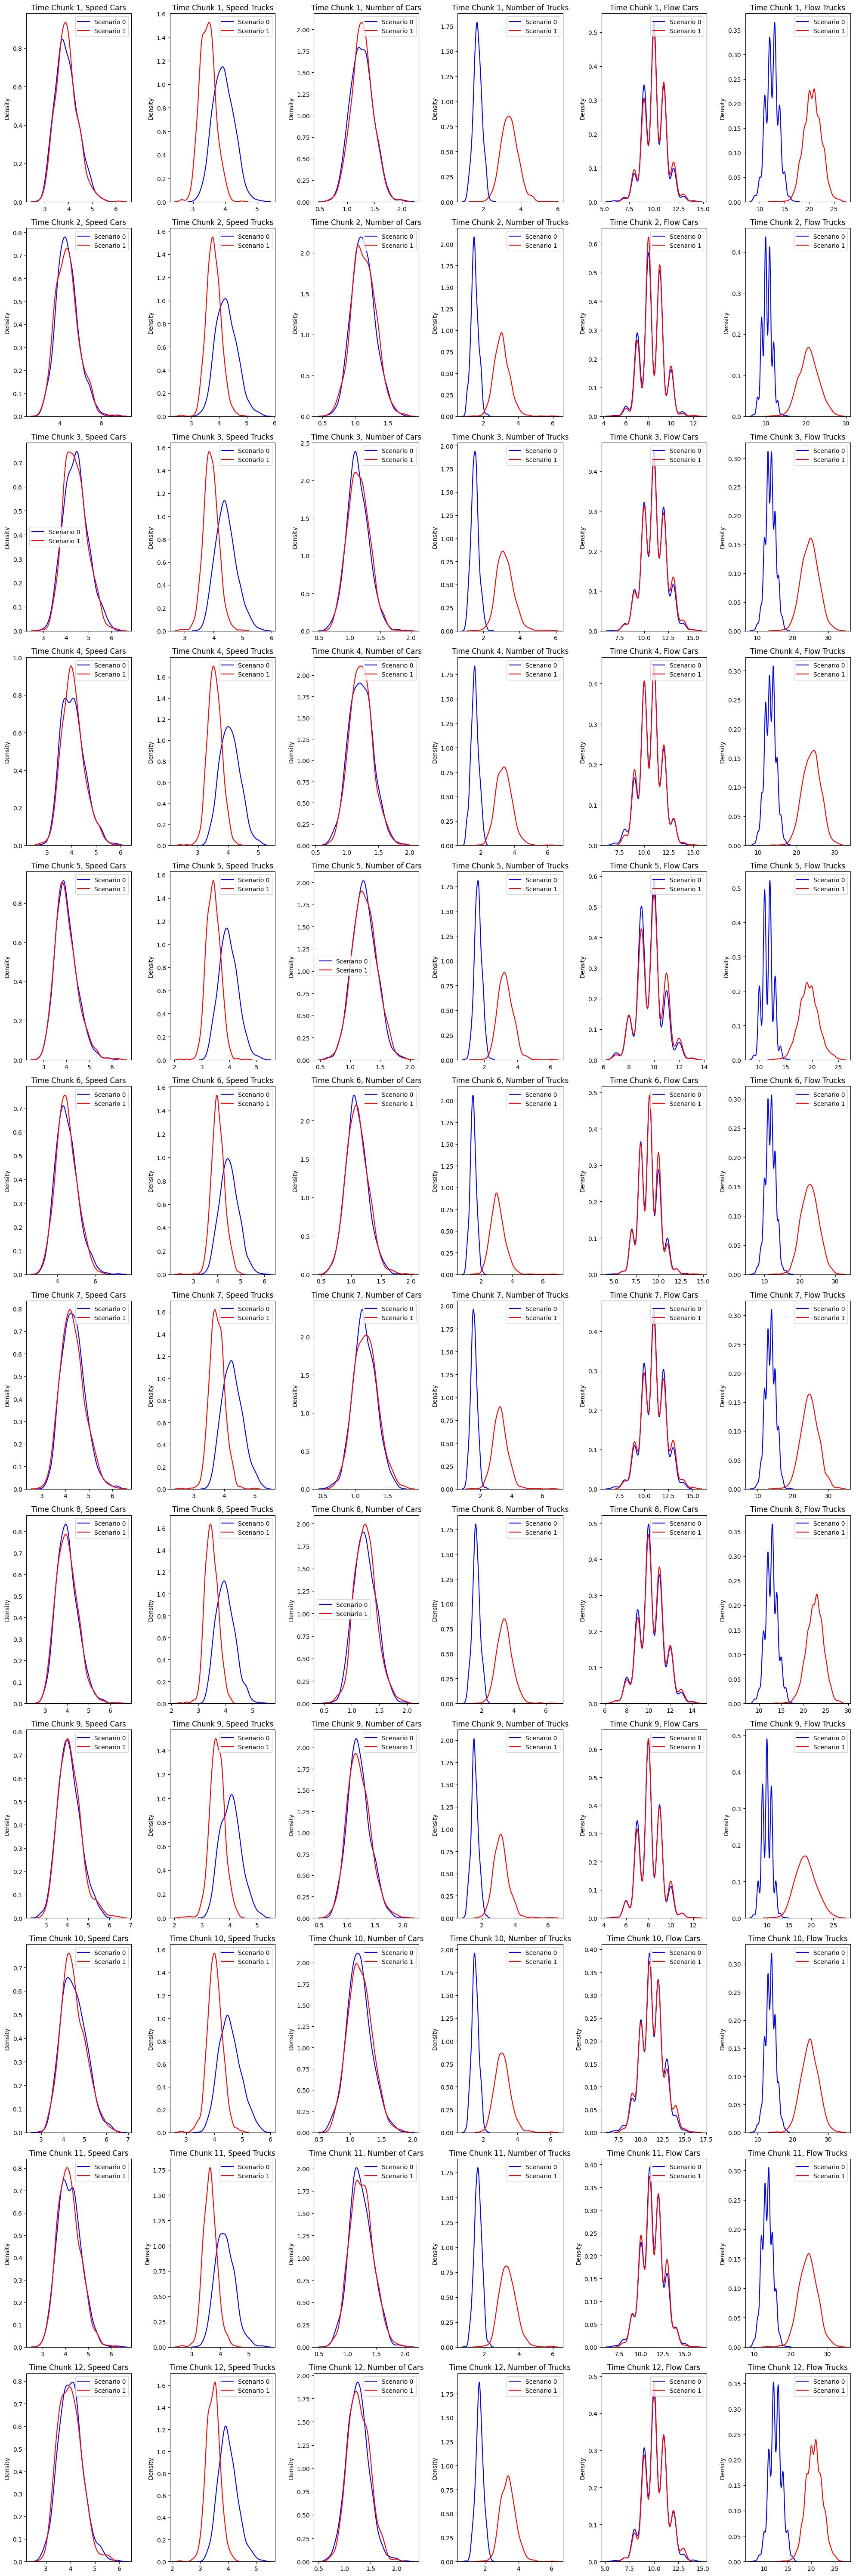

In [10]:
num_variables = len(variable_names)
num_segments = len(interesting_k)
num_timechunks = aggregated_s0.shape[2]

fig, axes = plt.subplots(num_timechunks, num_variables, figsize=(20, 5 * num_timechunks))

for t in range(num_timechunks):
    for v in range(num_variables):
        # Ensure data is 1D
        data_s0_temp = aggregated_s0[v, :, t]
        data_s1_temp = aggregated_s1[v, :, t]

        sns.kdeplot(data=data_s0_temp, ax=axes[t, v], label='Scenario 0', color='blue')
        sns.kdeplot(data=data_s1_temp, ax=axes[t, v], label='Scenario 1', color='red')

        axes[t, v].set_title(f"Time Chunk {t+1}, {variable_names[v]}")
        axes[t, v].legend()

plt.tight_layout()
plt.show()

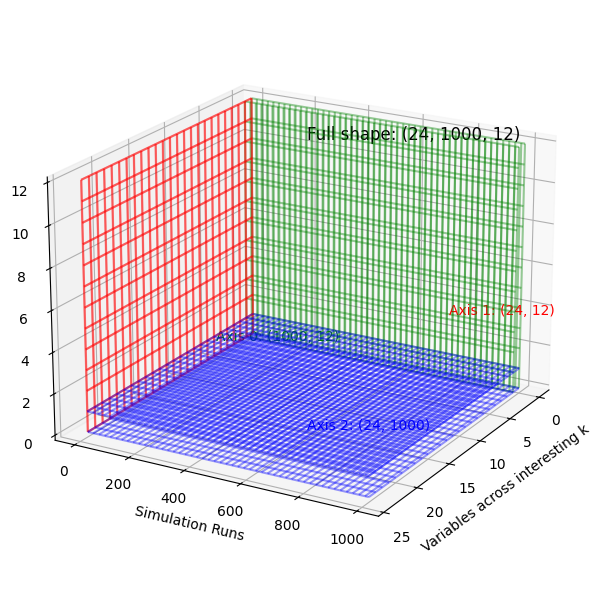

In [11]:
def visualize_array_shape(shape):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Create a grid for visualizing the array
    x, y, z = np.meshgrid(
        np.arange(shape[0] + 1),
        np.arange(shape[1] + 1),
        np.arange(shape[2] + 1)
    )

    # Draw the outer box
    for i in range(2):
        ax.plot_wireframe(x[i, :, :], y[i, :, :], z[i, :, :], color="red", alpha=0.4)  # Sides along axis 0
        ax.plot_wireframe(x[:, i, :], y[:, i, :], z[:, i, :], color="green", alpha=0.4)  # Sides along axis 1
        ax.plot_wireframe(x[:, :, i], y[:, :, i], z[:, :, i], color="blue", alpha=0.4)  # Sides along axis 2

    # Annotations
    ax.text(shape[0] // 2, shape[1] // 2, shape[2] + 1, f"Full shape: {shape}", color="black", fontsize=12)
    ax.text(shape[0] + 1, shape[1] // 2, shape[2] // 2, f"Axis 0: ({shape[1]}, {shape[2]})", color="green", fontsize=10)
    ax.text(shape[0] // 2, shape[1] + 1, shape[2] // 2, f"Axis 1: ({shape[0]}, {shape[2]})", color="red", fontsize=10)
    ax.text(shape[0] // 2, shape[1] // 2, -1, f"Axis 2: ({shape[0]}, {shape[1]})", color="blue", fontsize=10)

    # Adjust view and plot
    ax.view_init(20, 30)
    ax.set_xlabel("Variables across interesting k")
    ax.set_ylabel("Simulation Runs")
    ax.set_zlabel("Timechunks")
    plt.tight_layout()
    plt.show()

visualize_array_shape(aggregated_s0.shape)

In [12]:
def filter_aggregated_data(aggregated_data, variable_names):
    num_interesting_k = len(interesting_k)
    num_variables_total = len(variable_names) # Total number of variables

    # Find indices of the desired variables in the original variable list
    variable_indices = [variable_names.index(var_name) for var_name in variable_names]

    # Calculate the shape of the filtered data
    filtered_shape = (len(variable_names) * num_interesting_k, aggregated_data.shape[1], aggregated_data.shape[2])
    filtered_data = np.zeros(filtered_shape)

    # Iterate through the interesting k locations
    for i in range(num_interesting_k):
      # Iterate through each variable specified
        for j in range(len(variable_indices)):
          # Assign the original aggregated data to the filtered data
          filtered_data[i * len(variable_names) + j, :, :] = aggregated_data[i * num_variables_total + variable_indices[j], :, :]

    return filtered_data

## Batches Generation


### Case 1: Sampling Non-Overlapping Subsets

Randomly sample two non-overlapping subsets of days `(group1 and group2)` of size `B` from the data, without altering the dataset's dimensionality.

**Process:**
1. **Shuffling Indices:** Randomly shuffle the indices of num_runs (days) to ensure
randomness.
2. **Subsetting:** Select the first `B` indices for group1 and the next `B` indices for `group2`.
3. **Data Aggregation:** Extract data for the specified interesting segment `k` and the given time step `t`. The resulting groups have the same dimensionality as the original dataset for one time step.

**Dimensions:**
- **Input:**
  - `aggregated_data`: (`num_of_interesting_k` * `num_variables`, `num_runs`, `num_time_chunks`)
  - `batch_size` = B
  - `k`: Index for the interesting segment
  - `t`: Time step
  - `W`: Number of consecutive time steps (not used in the function, but kept so it is the same input for other cases)

- **Output (for one batch group):**
  - `group1` and `group2`: (`batch_size`, `num_variables`)
    - Each row corresponds to a day.
    - Each column corresponds to one variable from the interesting segment k.

In [13]:
def case1(aggregated_data, batch_size, t, k, W):
    # Shuffle and get indices for the two groups
    num_runs = aggregated_data.shape[1]
    num_variables = 6
    if(k==3): # case via di francia
      num_variables = 3
      variables_to_keep = ["Speed Cars", "Number of Cars", "Flow Cars"]
      aggregated_data = filter_aggregated_data(aggregated_data, variables_to_keep)


    group1_indices, group2_indices = get_shuffled_indices(num_runs, batch_size)

    # Extract groups
    group1 = aggregated_data[k * num_variables : (k + 1) * num_variables, group1_indices, t].T
    group2 = aggregated_data[k * num_variables : (k + 1) * num_variables, group2_indices, t].T

    return group1, group2

**Example:**
- For batch_size = 16, num_variables = 6, and k = 0:
  - group1 and group2 will each have shape (16, 6).


In [14]:
# Example usage
batch_size = 16
t = 0  # First timechunk
k = 0  # First interesting segment
group1_s0, group2_s0 = case1(aggregated_s0, batch_size, t, k, W)

# Check the shapes
print("Scenario 0")
print("Group1 shape:", group1_s0.shape)  # Should be (batch_size, num_variables)
print("Group2 shape:", group2_s0.shape)

Scenario 0
Group1 shape: (16, 6)
Group2 shape: (16, 6)


### Case 2: W > 1, Sampling Consecutive Measurements per Day

Aggregate `W` consecutive time steps for each sampled day into the same batch. Maintain the dimensionality of the original dataset by treating consecutive measurements as part of the same row.

**Process:**
1. **Adjusting Batch Size:** Divide the batch size by `W` to ensure we can sample the required number of days without exceeding the total size of `batch_size`.
2. **Consecutive Measurements:** Instead of sampling just one time step, extract W consecutive time steps for each day in the batch.
3. **Reshape:** Flatten the W consecutive time steps into one sample, maintaining the same number of columns (`num_variables`).

**Dimensions:**
- **Input:**
  - `aggregated_data`: (`num_of_interesting_k` * `num_variables`, `num_runs`, `num_time_chunks`)
  - `batch_size` = B
  - `W`: Number of consecutive time steps
  - `k`: Index for the interesting segment
  - `t`: Start time step

- **Output (for one batch group):**
  - `group1` and `group2`: (`batch_size`, `num_variables`)
    - The `W`consecutive time steps are concatenated into the same rows, maintaining the number of columns as `num_variables`.

In [15]:
def case2(aggregated_data, batch_size, t, k, W):
    num_variables = 6
    if(k==3): # case via di francia
      num_variables = 3
      variables_to_keep = ["Speed Cars", "Number of Cars", "Flow Cars"]
      aggregated_data = filter_aggregated_data(aggregated_data, variables_to_keep)

    num_runs = aggregated_data.shape[1]
    effective_batch_size = batch_size // W  # Adjust batch size to account for W
    group1_indices, group2_indices = get_shuffled_indices(num_runs, effective_batch_size)

    # Extract groups with consecutive measurements
    group1 = aggregated_data[k * num_variables : (k + 1) * num_variables, group1_indices, t:t + W].T
    group2 = aggregated_data[k * num_variables : (k + 1) * num_variables, group2_indices, t:t + W].T

    # Reshape to ensure fixed dimensionality (combine time points into samples)
    group1 = group1.reshape(-1, group1.shape[2])
    group2 = group2.reshape(-1, group2.shape[2])

    return group1, group2

**Example:**
- For batch_size = 16, W = 2, num_variables = 6, and k = 0:
  - effective_batch_size = 16 // 2 = 8 days per group.
  - The extracted shape from aggregated_data will be (6, 8, 2).
  - After reshaping: (16, 6).

In [16]:
# Example usage
W = 2  # Two consecutive measurements
group1, group2 = case2(aggregated_s0, batch_size, t, k, W)

# Check the shapes
print("Group1 shape:", group1.shape)  # Should still be (batch_size, num_variables)
print("Group2 shape:", group2.shape)

Group1 shape: (16, 6)
Group2 shape: (16, 6)


### Case 3: W > 1, Stacking Measurements as New Dimensions

Aggregate `W` consecutive time steps into a single vector for each day, increasing the number of variables per day by stacking measurements vertically.

**Process:**
1. **Batch Sampling:** Sample `B` days for `group1` and `group2`.
2. **Stacking Time Steps:** For each day, extract `W` consecutive time steps and stack them along the variable dimension.
3. **Resulting Groups:** The resulting batches will have `num_variables` * `W` columns, as each time step adds new variables.

**Dimensions:**
- **Input:**
  - `aggregated_data`: (`num_of_interesting_k` * `num_variables`, `num_runs`, `num_time_chunks`)
  - `batch_size` = B
  - `W`: Number of consecutive time steps
  - `k`: Index for the interesting segment
  - `t`: Start time step

- **Output (for one batch group):**
  - `group1` and `group2`: (`batch_size`, `num_variables` * `W`)
    - Each row corresponds to one sampled day.
    - Each column represents a variable or stacked time step.

In [17]:
def case3(aggregated_data, batch_size, t, k, W):
    num_variables = 6
    if(k==3): # case via di francia
      num_variables = 3
      variables_to_keep = ["Speed Cars", "Number of Cars", "Flow Cars"]
      aggregated_data = filter_aggregated_data(aggregated_data, variables_to_keep)

    num_runs = aggregated_data.shape[1]
    group1_indices, group2_indices = get_shuffled_indices(num_runs, batch_size)

    # Stack W measurements as additional components
    group1 = np.concatenate(
        [aggregated_data[k * num_variables : (k + 1) * num_variables, group1_indices, t + i] for i in range(W)],
        axis=0,
    ).T
    group2 = np.concatenate(
        [aggregated_data[k * num_variables : (k + 1) * num_variables, group2_indices, t + i] for i in range(W)],
        axis=0,
    ).T

    return group1, group2

**Example:**
- For batch_size = 16, W = 3, num_variables = 6, and k = 0:
  - The stacked shape for one day will be (6 * 3 = 18) variables.
  - group1 and group2 will each have shape (16, 18).

In [18]:
# Example usage
W = 3  # Stack three consecutive measurements
group1, group2 = case3(aggregated_s0, batch_size, t, k, W)

# Check the shapes
print("Group1 shape:", group1.shape)  # Should be (batch_size, num_variables * W)
print("Group2 shape:", group2.shape)

Group1 shape: (16, 18)
Group2 shape: (16, 18)


### Batch Generation Over All Time Steps
This function generates batches `(group1, group2)` for all time steps and returns a list of batches.

In [19]:
def generate_batches_over_time(
    aggregated_data, batch_size, k, W, case_function, case_name="Case"
):
    """
    Generate batches for all time steps using the specified case function.

    Parameters:
    - aggregated_data: The dataset (NumPy array).
    - batch_size: Size of the batch.
    - k: Index of the interesting segment.
    - W: Number of consecutive measurements.
    - case_function: The function to use for batch generation (case1, case2, case3).
    - case_name: Name of the case for debugging and visualization.

    Returns:
    - List of (group1, group2) tuples for all time steps.
    """
    num_time_chunks = aggregated_data.shape[2]
    batches = []

    for t in range(num_time_chunks - W + 1):  # Ensure W fits in the time chunks
        try:
            group1, group2 = case_function(aggregated_data, batch_size, t, k, W)
            batches.append((group1, group2))
        except ValueError as e:
            print(f"Skipping time step {t} due to error: {e}")

    # print(f"{case_name}: Generated {len(batches)} batches over all time steps.")
    return batches


In [20]:
#Testing generation of batches

batches_case1 = generate_batches_over_time(
    aggregated_s0, batch_size=16, k=0, W=1, case_function=case1, case_name="Case 1"
)

print(np.shape(batches_case1))

(12, 2, 16, 6)


## TWO-SAMPLE HOTELLING'S T2 TEST

#### Two-Sample Hotelling's T^2 Test Implementation

The null hypothesis is that the two groups have the same multivariate mean

In [21]:
def hotelling_t2_test(group1, group2):
    """
    Perform the two-sample Hotelling's T² test.

    Parameters:
        group1 (ndarray): Data for group 1, shape (n1, p)
        group2 (ndarray): Data for group 2, shape (n2, p)

    Returns:
        dict: A dictionary containing T² statistic, F-statistic, degrees of freedom, and p-value.
    """
    # Sizes of the groups
    n1, p = group1.shape
    n2, _ = group2.shape

    # Means of each group
    mean1 = np.mean(group1, axis=0)
    mean2 = np.mean(group2, axis=0)

    # Covariance matrices for each group
    S1 = np.cov(group1, rowvar=False)
    S2 = np.cov(group2, rowvar=False)

    # Pooled covariance matrix
    Sp = ((n1 - 1) * S1 + (n2 - 1) * S2) / (n1 + n2 - 2)

    # Mean difference
    mean_diff = mean1 - mean2

    # Hotelling's T² statistic
    T2_stat = (n1 * n2) / (n1 + n2) * mean_diff @ np.linalg.pinv(Sp) @ mean_diff.T

    # Convert T² statistic to an F-statistic
    F_stat = (T2_stat * (n1 + n2 - p - 1)) / (p * (n1 + n2 - 2))
    df1 = p  # Degrees of freedom 1
    df2 = n1 + n2 - p - 1  # Degrees of freedom 2

    # p-value
    p_value = 1 - f.cdf(F_stat, df1, df2)

    # Return results
    return {
        "T2_statistic": T2_stat,
        "F_statistic": F_stat,
        "df1": df1,
        "df2": df2,
        "p_value": p_value
    }

#### Testing Implementation

Testing the Code

To ensure correctness, you can test your function with 3 examples that involve:

    Small data matrices (easy to verify manually).
    Larger datasets to confirm computational stability.
    Edge cases (e.g., groups with identical means, extreme covariance values).

Test 1: Small, Simple Data

Manually compute expected results for two small groups.

Expected result: moderate T2 statistic and a small p-value, indicating significant differences between groups.

In [22]:
group1 = np.array([[4.2, 2.5], [3.9, 2.7], [4.3, 2.8]])
group2 = np.array([[5.1, 3.3], [5.3, 3.1], [5.0, 3.5]])

result = hotelling_t2_test(group1, group2)
print("Test 1:", result)

Test 1: {'T2_statistic': 110.51177904143, 'F_statistic': 41.44191714053625, 'df1': 2, 'df2': 3, 'p_value': 0.0065285200794436005}


Test 2: Larger Groups

Introduce larger groups and verify statistical results.

Expected result: a larger T2 statistic and a very small p-value (assuming noticeable group differences).

In [23]:
np.random.seed(42)  # For reproducibility
group1 = np.random.multivariate_normal([5, 10, 15], np.eye(3), size=50)
group2 = np.random.multivariate_normal([6, 11, 16], np.eye(3), size=50)

result = hotelling_t2_test(group1, group2)
print("Test 2:", result)


Test 2: {'T2_statistic': 144.64908762851974, 'F_statistic': 47.23235514400645, 'df1': 3, 'df2': 96, 'p_value': 1.1102230246251565e-16}


Test 3: Identical Means

Use groups with pratically identical means; T2 and F-statistic should be 0, and p-value should be 1.0.

Expected result: small T2, near zero F, and p prox. to 1.0 (pratically no group difference).

In [24]:
group1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
group2 = group1.copy()

result = hotelling_t2_test(group1, group2)
print("Test 3:", result)

Test 3: {'T2_statistic': 0.0, 'F_statistic': 0.0, 'df1': 3, 'df2': 2, 'p_value': 1.0}


### Apply Hotelling

In [25]:
# Iterate through time steps and apply Hotelling's T2 test
def calculate_hotelling_same_scenario(batches):
  results = []
  for t in range(len(batches)):
    group1, group2 = batches[t]
    result = hotelling_t2_test(group1, group2)
    results.append(result)
  return results


def calculate_hotelling_between_scenarios(batches_s0, batches_s1, group=0):
  results = []
  for t in range(len(batches_s0)):
    result = hotelling_t2_test(batches_s0[t][group], batches_s1[t][group])
    results.append(result)
  return results

def print_hotelling_results(results, description):
  print(description)
  results = pd.DataFrame(results)
  print(results)
  print()

In [26]:
def hotelling_iterate_batch_sizes(k, W, case_type, case_descrp):

  key = next((key for key, val in index_segments_k.items() if val == k), None)
  print(f"The segment of interest is: {key}")
  print(f"Case Type: {case_descrp}")
  print(f"W: {W}")

  print()

  for B in batch_sizes:
    print(f"Batch size: {B}")

    batches_s0 = generate_batches_over_time(
      aggregated_s0, batch_size=B, k=k, W=W, case_function=case_type, case_name="Scenario 0"
    )
    batches_s1 = generate_batches_over_time(
      aggregated_s1, batch_size=B, k=k, W=W, case_function=case_type, case_name="Scenario 1"
    )

    print()

    results_s0 = calculate_hotelling_same_scenario(batches_s0)
    results_s1 = calculate_hotelling_same_scenario(batches_s1)
    results_between_scenarios_group0 = calculate_hotelling_between_scenarios(batches_s0, batches_s1, group=0)
    results_between_scenarios_group1 = calculate_hotelling_between_scenarios(batches_s0, batches_s1, group=1)

    print_hotelling_results(results_s0, "Scenario 0")
    print_hotelling_results(results_s1, "Scenario 1")
    print_hotelling_results(results_between_scenarios_group0, "Between Scenarios, Group 0")
    print_hotelling_results(results_between_scenarios_group1, "Between Scenarios, Group 1")

    print()


### Segment 6 - Elicoidale Downstream

In [27]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Downstream"], W=1, case_type=case1, case_descrp="Case 1")

The segment of interest is: Elicoidale Downstream
Case Type: Case 1
W: 1

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      18.899587     2.024956    6    9  0.164041
1      15.557286     1.666852    6    9  0.235448
2       5.903692     0.632538    6    9  0.702822
3       4.998857     0.535592    6    9  0.769624
4       3.815423     0.408795    6    9  0.855742
5       7.348394     0.787328    6    9  0.601364
6       6.082309     0.651676    6    9  0.689831
7       2.272149     0.243444    6    9  0.950236
8      16.244506     1.740483    6    9  0.218250
9       3.820081     0.409294    6    9  0.855416
10     13.038445     1.396976    6    9  0.312782
11     23.585863     2.527057    6    9  0.102171

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0      22.620896     2.423667    6    9  0.112277
1       8.210800     0.879729    6    9  0.545754
2      13.296059     1.424578    6    9  0.303711
3      16.069446     1.721726    6    

In [28]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Downstream"], W=2, case_type=case2, case_descrp="Case 2")

The segment of interest is: Elicoidale Downstream
Case Type: Case 2
W: 2

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      20.486186     2.194949    6    9  0.139135
1      11.037259     1.182563    6    9  0.393926
2       5.851688     0.626967    6    9  0.706621
3       5.810216     0.622523    6    9  0.709657
4      13.254376     1.420112    6    9  0.305159
5      45.029935     4.824636    6    9  0.017926
6       8.239695     0.882824    6    9  0.543964
7       3.022793     0.323871    6    9  0.908325
8       5.737729     0.614757    6    9  0.714972
9       1.854995     0.198749    6    9  0.968779
10      3.434550     0.367988    6    9  0.881813

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0       3.343499     0.358232    6    9  0.887844
1       7.627000     0.817179    6    9  0.582945
2      11.483804     1.230408    6    9  0.374077
3       4.168178     0.446590    6    9  0.830648
4      40.921961     4.384496    6    

In [29]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Downstream"], W=3, case_type=case3, case_descrp="Case 3")

The segment of interest is: Elicoidale Downstream
Case Type: Case 3
W: 3

Batch size: 8

Scenario 0
   T2_statistic  F_statistic  df1  df2  p_value
0    325.812631    -3.878722   18   -3      NaN
1    169.752874    -2.020868   18   -3      NaN
2    133.999052    -1.595227   18   -3      NaN
3    340.730581    -4.056316   18   -3      NaN
4     20.635622    -0.245662   18   -3      NaN
5    101.563133    -1.209085   18   -3      NaN
6     50.743812    -0.604093   18   -3      NaN
7     99.994450    -1.190410   18   -3      NaN
8     22.235526    -0.264709   18   -3      NaN
9    196.161173    -2.335252   18   -3      NaN

Scenario 1
   T2_statistic  F_statistic  df1  df2  p_value
0   3182.653136   -37.888728   18   -3      NaN
1     66.046507    -0.786268   18   -3      NaN
2     27.111728    -0.322759   18   -3      NaN
3    172.494867    -2.053510   18   -3      NaN
4     44.762470    -0.532887   18   -3      NaN
5     79.945711    -0.951735   18   -3      NaN
6    266.506061    -3.17

### Segment 43 - Lungomare Canepa

In [30]:
hotelling_iterate_batch_sizes(k=index_segments_k["Lungomare Canepa"], W=1, case_type=case1, case_descrp="Case 1")

The segment of interest is: Lungomare Canepa
Case Type: Case 1
W: 1

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      26.758584     2.866991    6    9  0.075773
1       9.288606     0.995208    6    9  0.482336
2      11.270063     1.207507    6    9  0.383446
3      12.409577     1.329598    6    9  0.336180
4      12.785992     1.369928    6    9  0.321957
5      13.538526     1.450556    6    9  0.295434
6      62.843451     6.733227    6    9  0.006093
7       5.593455     0.599299    6    9  0.725586
8       5.265668     0.564179    6    9  0.749830
9      17.758562     1.902703    6    9  0.185179
10     35.041766     3.754475    6    9  0.037377
11     10.218057     1.094792    6    9  0.433166

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0       3.949565     0.423168    6    9  0.846289
1      36.759630     3.938532    6    9  0.032667
2       2.849384     0.305291    6    9  0.918831
3       8.559755     0.917117    6    9  0.

In [31]:
hotelling_iterate_batch_sizes(k=index_segments_k["Lungomare Canepa"], W=2, case_type=case2, case_descrp="Case 2")

The segment of interest is: Lungomare Canepa
Case Type: Case 2
W: 2

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      19.909852     2.133198    6    9  0.147635
1      14.721744     1.577330    6    9  0.258453
2      18.011406     1.929793    6    9  0.180236
3      36.980377     3.962183    6    9  0.032115
4      24.972308     2.675604    6    9  0.089474
5       9.360993     1.002964    6    9  0.478324
6      18.234250     1.953670    6    9  0.176005
7       6.505558     0.697024    6    9  0.659483
8      47.322159     5.070231    6    9  0.015372
9       5.105007     0.546965    6    9  0.761748
10     78.191316     8.377641    6    9  0.002843

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0      12.553408     1.345008    6    9  0.330667
1      11.751278     1.259065    6    9  0.362687
2       8.009733     0.858186    6    9  0.558343
3      62.778637     6.726283    6    9  0.006115
4      95.737406    10.257579    6    9  0.

In [32]:
hotelling_iterate_batch_sizes(k=index_segments_k["Lungomare Canepa"], W=3, case_type=case3, case_descrp="Case 3")

The segment of interest is: Lungomare Canepa
Case Type: Case 3
W: 3

Batch size: 8

Scenario 0
   T2_statistic  F_statistic  df1  df2  p_value
0     32.054963    -0.381607   18   -3      NaN
1     72.239886    -0.859999   18   -3      NaN
2    201.476999    -2.398536   18   -3      NaN
3    366.455409    -4.362564   18   -3      NaN
4    165.506368    -1.970314   18   -3      NaN
5     91.171387    -1.085374   18   -3      NaN
6    191.101070    -2.275013   18   -3      NaN
7    259.283489    -3.086708   18   -3      NaN
8    108.484274    -1.291479   18   -3      NaN
9    430.910643    -5.129889   18   -3      NaN

Scenario 1
   T2_statistic  F_statistic  df1  df2  p_value
0    135.319724    -1.610949   18   -3      NaN
1     71.382119    -0.849787   18   -3      NaN
2    143.211148    -1.704895   18   -3      NaN
3     58.795813    -0.699950   18   -3      NaN
4    129.459488    -1.541184   18   -3      NaN
5     65.982768    -0.785509   18   -3      NaN
6     37.429798    -0.445593 

### Segment 62 - Elicoidale Upstream

In [33]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Upstream"], W=1, case_type=case1, case_descrp="Case 1")

The segment of interest is: Elicoidale Upstream
Case Type: Case 1
W: 1

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      13.136080     1.407437    6    9  0.309310
1      11.276266     1.208171    6    9  0.383170
2       5.819608     0.623529    6    9  0.708969
3       4.729414     0.506723    6    9  0.789583
4      13.222843     1.416733    6    9  0.306259
5       3.896315     0.417462    6    9  0.850056
6       7.460111     0.799298    6    9  0.593928
7       3.872203     0.414879    6    9  0.851755
8      32.558854     3.488449    6    9  0.045720
9      10.058150     1.077659    6    9  0.441267
10     18.466095     1.978510    6    9  0.171725
11      3.180265     0.340743    6    9  0.898426

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0       3.547923     0.380135    6    9  0.874187
1      12.775532     1.368807    6    9  0.322344
2       4.477260     0.479706    6    9  0.808154
3       4.661369     0.499432    6    9 

In [34]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Upstream"], W=2, case_type=case2, case_descrp="Case 2")

The segment of interest is: Elicoidale Upstream
Case Type: Case 2
W: 2

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0      21.697751     2.324759    6    9  0.123066
1       4.329287     0.463852    6    9  0.818969
2      12.104727     1.296935    6    9  0.348190
3      16.828497     1.803053    6    9  0.204752
4       3.029928     0.324635    6    9  0.907883
5      10.700416     1.146473    6    9  0.409609
6      10.700152     1.146445    6    9  0.409621
7      31.740624     3.400781    6    9  0.048950
8       4.450756     0.476867    6    9  0.810097
9       9.548793     1.023085    6    9  0.468061
10      2.139844     0.229269    6    9  0.956534

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0      34.958446     3.745548    6    9  0.037625
1      10.910592     1.168992    6    9  0.399750
2      15.513398     1.662150    6    9  0.236598
3       3.861825     0.413767    6    9  0.852486
4       3.670293     0.393246    6    9 

In [35]:
hotelling_iterate_batch_sizes(k=index_segments_k["Elicoidale Upstream"], W=3, case_type=case3, case_descrp="Case 3")

The segment of interest is: Elicoidale Upstream
Case Type: Case 3
W: 3

Batch size: 8

Scenario 0
   T2_statistic  F_statistic  df1  df2  p_value
0    181.528292    -2.161051   18   -3      NaN
1    161.489946    -1.922499   18   -3      NaN
2    106.283504    -1.265280   18   -3      NaN
3    135.699334    -1.615468   18   -3      NaN
4     53.843099    -0.640989   18   -3      NaN
5    254.929450    -3.034874   18   -3      NaN
6     10.070662    -0.119889   18   -3      NaN
7    168.255828    -2.003046   18   -3      NaN
8   1653.428820   -19.683676   18   -3      NaN
9    239.989320    -2.857016   18   -3      NaN

Scenario 1
   T2_statistic  F_statistic  df1  df2  p_value
0    160.032269    -1.905146   18   -3      NaN
1    547.945463    -6.523160   18   -3      NaN
2     45.177658    -0.537829   18   -3      NaN
3    257.125562    -3.061019   18   -3      NaN
4    108.748380    -1.294624   18   -3      NaN
5    543.712125    -6.472763   18   -3      NaN
6    150.779280    -1.7949

### Segment 70 - Via di Francia

In [36]:
hotelling_iterate_batch_sizes(k=index_segments_k["Via di Francia"], W=1, case_type=case1, case_descrp="Case 1")

The segment of interest is: Via di Francia
Case Type: Case 1
W: 1

Batch size: 8

Scenario 0
    T2_statistic  F_statistic  df1  df2   p_value
0       3.861647     1.103328    3   12  0.385733
1      11.097289     3.170654    3   12  0.063702
2       2.653893     0.758255    3   12  0.538738
3       5.928141     1.693754    3   12  0.221163
4       2.790994     0.797427    3   12  0.518695
5       2.409102     0.688315    3   12  0.576350
6      11.446364     3.270390    3   12  0.059008
7       0.842167     0.240619    3   12  0.866346
8       2.201700     0.629057    3   12  0.610069
9       0.699255     0.199787    3   12  0.894522
10      4.375975     1.250278    3   12  0.335010
11      3.306708     0.944774    3   12  0.449644

Scenario 1
    T2_statistic  F_statistic  df1  df2   p_value
0       6.317691     1.805055    3   12  0.199843
1       4.870461     1.391560    3   12  0.292960
2       0.534143     0.152612    3   12  0.926002
3       1.212162     0.346332    3   12  0.79

In [37]:
hotelling_iterate_batch_sizes(k=index_segments_k["Via di Francia"], W=3, case_type=case3, case_descrp="Case 3")

The segment of interest is: Via di Francia
Case Type: Case 3
W: 3

Batch size: 8

Scenario 0
   T2_statistic  F_statistic  df1  df2   p_value
0     24.405638     1.162173    9    6  0.442995
1     24.424551     1.163074    9    6  0.442603
2     11.433608     0.544458    9    6  0.802109
3    105.992404     5.047257    9    6  0.030991
4     42.836069     2.039813    9    6  0.199069
5     23.187611     1.104172    9    6  0.469084
6      2.581492     0.122928    9    6  0.996843
7     47.831532     2.277692    9    6  0.164282
8     16.636904     0.792234    9    6  0.638558
9     53.770007     2.560477    9    6  0.132449

Scenario 1
   T2_statistic  F_statistic  df1  df2   p_value
0     18.962293     0.902966    9    6  0.572731
1     40.903118     1.947768    9    6  0.215031
2     19.919378     0.948542    9    6  0.547426
3     15.591492     0.742452    9    6  0.669999
4     23.148192     1.102295    9    6  0.469956
5     12.790932     0.609092    9    6  0.758352
6     20.0360

In [38]:
hotelling_iterate_batch_sizes(k=index_segments_k["Via di Francia"], W=3, case_type=case3, case_descrp="Case 3")

The segment of interest is: Via di Francia
Case Type: Case 3
W: 3

Batch size: 8

Scenario 0
   T2_statistic  F_statistic  df1  df2   p_value
0     16.066508     0.765072    9    6  0.655583
1     59.460465     2.831451    9    6  0.109065
2     59.914993     2.853095    9    6  0.107437
3     47.759296     2.274252    9    6  0.164727
4     11.849777     0.564275    9    6  0.788712
5     40.779511     1.941881    9    6  0.216106
6     13.998117     0.666577    9    6  0.719703
7     31.031130     1.477673    9    6  0.327025
8      5.719754     0.272369    9    6  0.960234
9     28.160031     1.340954    9    6  0.372293

Scenario 1
   T2_statistic  F_statistic  df1  df2   p_value
0     12.160607     0.579077    9    6  0.778684
1     78.667354     3.746064    9    6  0.060987
2     18.008369     0.857541    9    6  0.599008
3      2.577260     0.122727    9    6  0.996861
4     11.913443     0.567307    9    6  0.786659
5     15.180436     0.722878    9    6  0.682635
6     13.2213

## FALSE POSITIVE RATE (FPR)


In [39]:
def calculate_false_positive_rate(aggregated_data, N, interesting_k, W, batch_sizes, case_function, significance_level):
    """
    Calculates the false positive rate for a given scenario.

    Args:
        aggregated_data: The aggregated data to extract the batches from.
        N: Number of iterations.
        interesting_k: Index of the interesting segment.
        W: Window size.
        batch_sizes: List of batch sizes to test.
        case_function: The batch generation function (case1, case2, or case3).
        significance_level: The significance level for the Hotelling's T2 test.

    Returns:
        A dictionary where keys are batch sizes and values are the false positive rates.
    """

    false_positive_rates = {}
    for B in batch_sizes:
        false_positives = 0
        i=0
        for _ in range(N):
            batches = generate_batches_over_time(
                aggregated_data, batch_size=B, k=interesting_k, W=W, case_function=case_function
            )
            results = calculate_hotelling_same_scenario(batches)
            # Count false positives (p-value < significance level) within the same scenario
            for result in results:
                i = i + 1
                if result["p_value"] < significance_level:
                    false_positives += 1
                    break #Consider only one false positive per iteration

        false_positive_rates[B] = false_positives / i
    return false_positive_rates

In [40]:
def calculate_fpr_segments_stacked(aggregated_data, N, W, batch_sizes, case_function, significance_level):
    """
    Calculates the false positive rate for a given scenario.

    Args:
        aggregated_data: The aggregated data to extract the batches from.
        N: Number of iterations.
        interesting_k: Index of the interesting segment.
        W: Window size.
        batch_sizes: List of batch sizes to test.
        case_function: The batch generation function (case1, case2, or case3).
        significance_level: The significance level for the Hotelling's T2 test.

    Returns:
        A dictionary where keys are batch sizes and values are the false positive rates.
    """

    false_positive_rates = {}
    for B in batch_sizes:
        false_positives = 0
        i=0
        for _ in range(N):
            segment_batches = []
            for this_k in index_segments_k.values():
                batches = generate_batches_over_time(
                    aggregated_data, batch_size=B, k=this_k, W=W, case_function=case_function
                )
                segment_batches.append(batches)

            stacked_batches = np.hstack(segment_batches) # ver dps se esse hstack eh o que queriamos msm

            print(f"Stacked batch dimensions: {stacked_batches.shape}")

            results = calculate_hotelling_same_scenario(stacked_batches)
            # Count false positives (p-value < significance level) within the same scenario
            for result in results:
                i = i + 1
                if result["p_value"] < significance_level:
                    false_positives += 1
                    break #Consider only one false positive per iteration

        false_positive_rates[B] = false_positives / i
    return false_positive_rates

In [41]:
def calculate_fpr_for_significance_levels(aggregated_data, N, interesting_k, W, batch_sizes, case_function, significance_levels):
    """
    Calculate the False Positive Rate (FPR) for a range of significance levels.

    Args:
        aggregated_data: The aggregated data to extract the batches from.
        N: Number of iterations.
        interesting_k: Index of the interesting segment.
        W: Window size.
        batch_sizes: List of batch sizes to test.
        case_function: The batch generation function (case1, case2, or case3).
        significance_levels: A range or list of significance levels to evaluate.

    Returns:
        A dictionary where keys are batch sizes and values are lists of FPRs corresponding to the significance levels.
    """
    results = {batch_size: [] for batch_size in batch_sizes}

    for alpha in significance_levels:
        fpr_results = calculate_false_positive_rate(
            aggregated_data, N, interesting_k, W, batch_sizes, case_function, significance_level=alpha
        )
        for batch_size, fpr in fpr_results.items():
            results[batch_size].append(fpr)

    return results

In [42]:
def plot_fpr_vs_significance_level(fpr_results, significance_levels):
    """
    Plot the False Positive Rate (FPR) as a function of the significance level.

    Args:
        fpr_results: A dictionary where keys are batch sizes and values are lists of FPRs.
        significance_levels: A list of significance levels corresponding to the FPRs.
    """
    plt.figure(figsize=(10, 6))

    for batch_size, fprs in fpr_results.items():
        plt.plot(significance_levels, fprs, label=f"Batch Size {batch_size}", marker='o')

    plt.axline((0, 0), slope=1, color='gray', linestyle='--', label="y = x (reference)")
    plt.title("False Positive Rate vs. Significance Level")
    plt.xlabel("Significance Level")
    plt.ylabel("False Positive Rate (FPR)")
    #plt.yscale('log')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

In [43]:
def transform_fpr_results(fpr_results, significance_levels):
    """
    Transforms the FPR results and significance levels into a pandas DataFrame.

    Args:
        fpr_results (dict): A dictionary where keys are batch sizes and values are lists of FPRs.
        significance_levels (list): A list of significance levels.

    Returns:
        pandas.DataFrame: A DataFrame containing the FPR results.
    """

    data = []
    for batch_size, fprs in fpr_results.items():
        for i, fpr in enumerate(fprs):
            data.append({
                "Batch Size": batch_size,
                "Significance Level": significance_levels[i],
                "FPR (Sanity Check)": fpr
            })

    return pd.DataFrame(data)

In [44]:
def transform_fpr_results_2(fpr_gaussian, fpr_results_s0, fpr_results_s1, significance_levels):
    """
    Transforms the FPR results of both scenarios and significance levels into a pandas DataFrame.

    Args:
        fpr_gaussian (dict): FPR results for the Gaussian distribution sanity check.
        fpr_results_s0 (dict): FPR results for scenario 0.
        fpr_results_s1 (dict): FPR results for scenario 1.
        significance_levels (list): List of significance levels.

    Returns:
        pandas.DataFrame: A DataFrame with the specified columns.
    """
    data = []
    for batch_size in fpr_results_s0:  # Assuming all dictionaries have the same keys
        for i, alpha in enumerate(significance_levels):
            data.append({
                'Batch Size': batch_size,
                'Significance Level': alpha,
                'FPR Sanity Check': fpr_gaussian[batch_size][i],
                'FPR Scenario 0': fpr_results_s0[batch_size][i],
                'FPR Scenario 1': fpr_results_s1[batch_size][i],
            })
    return pd.DataFrame(data)

In [45]:
def plot_fpr_subplots(df):
    """
    Plots FPR Mean and FPR Sanity Check for different batch sizes in separate subplots.
    """
    batch_sizes = df['Batch Size'].unique()
    num_plots = len(batch_sizes)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))  # Adjust figsize as needed

    if num_plots == 1:
      axes = [axes]

    for i, batch_size in enumerate(batch_sizes):
        df_batch = df[df['Batch Size'] == batch_size]
        axes[i].plot(df_batch['Significance Level'], df_batch['FPR Scenario 0'], label='FPR S0 - Hotelling T2', marker='o')
        axes[i].plot(df_batch['Significance Level'], df_batch['FPR Scenario 1'], label='FPR S1 - Hotelling T2', marker='o')
        axes[i].plot(df_batch['Significance Level'], df_batch['FPR Sanity Check'], label='FPR - Sanity Check', marker='x')
        axes[i].axline((0, 0), slope=1, color='gray', linestyle='--', label="y = x")
        axes[i].set_title(f"Batch Size {batch_size}")
        axes[i].set_xlabel("Significance Levels")
        axes[i].set_ylabel("FPR")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

In [52]:
significance_levels = [0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
print(significance_levels)

N = 5000

[0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]


### Gaussian Distribution

In [53]:
# Example usage
gaussian_data = np.random.normal(loc=0.0, scale=1.0, size=(4*6, 1000, 12))
print(gaussian_data.shape)
print(np.mean(gaussian_data)) #check the mean is close to 0

(24, 1000, 12)
-0.00564149853839204


In [54]:
# Calculate FPR for the range of significance levels
fpr_gaussian = calculate_fpr_for_significance_levels(
    gaussian_data, N, index_segments_k["Elicoidale Upstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

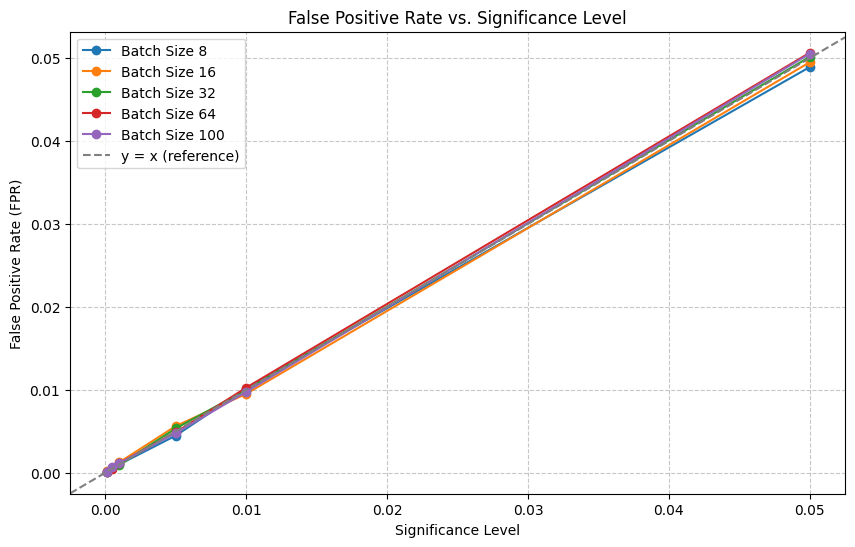

In [55]:
# Plot the results
plot_fpr_vs_significance_level(fpr_gaussian, significance_levels)

In [56]:
df_gaussian = transform_fpr_results(fpr_gaussian, significance_levels)
df_gaussian

Batch Size  Significance Level  FPR (Sanity Check)
0            8              0.0500            0.048918
1            8              0.0100            0.010137
2            8              0.0050            0.004470
3            8              0.0010            0.001006
4            8              0.0005            0.000568
5            8              0.0001            0.000083
6           16              0.0500            0.049495
7           16              0.0100            0.009509
8           16              0.0050            0.005622
9           16              0.0010            0.001259
10          16              0.0005            0.000552
11          16              0.0001            0.000150
12          32              0.0500            0.050146
13          32              0.0100            0.009986
14          32              0.0050            0.005338
15          32              0.0010            0.000938
16          32              0.0005            0.000619
17          32              0.0001            0.000083
18          64              0.0500            0.050641
19          64              0.0100            0.010253
20          64              0.0050            0.004862
21          64              0.0010            0.001141
22          64              0.0005            0.000485
23          64              0.0001            0.000117
24         100              0.0500            0.050522
25         100              0.0100            0.009749
26         100              0.0050            0.004787
27         100              0.0010            0.001141
28         100              0.0005            0.000636
29         100              0.0001            0.000100

### Uniform Data

In [93]:
# Example usage for uniform distribution
uniform_data = np.random.uniform(low=-1.0, high=1.0, size=(4*6, 1000, 12))
print(uniform_data.shape)  # Print the shape of the generated array
print(np.mean(uniform_data))

(24, 1000, 12)
-0.000733828240274693


In [99]:
# Calculate FPR for the range of significance levels
fpr_uniform = calculate_fpr_for_significance_levels(
    uniform_data, N, index_segments_k["Elicoidale Upstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

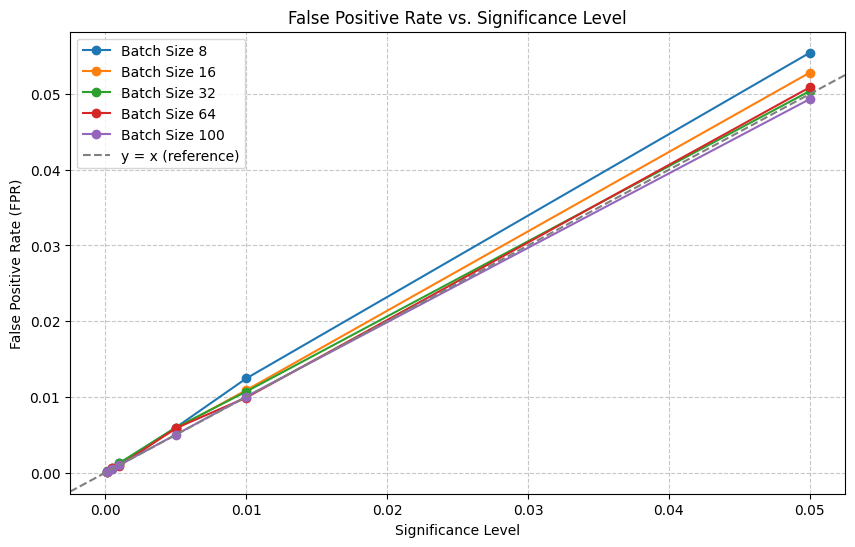

In [100]:
# Plot the results
plot_fpr_vs_significance_level(fpr_uniform, significance_levels)

In [101]:
df_uniform = transform_fpr_results(fpr_uniform, significance_levels)
df_uniform

Batch Size  Significance Level  FPR (Sanity Check)
0            8              0.0500            0.055451
1            8              0.0100            0.012441
2            8              0.0050            0.005957
3            8              0.0010            0.001225
4            8              0.0005            0.000635
5            8              0.0001            0.000167
6           16              0.0500            0.052827
7           16              0.0100            0.010894
8           16              0.0050            0.005793
9           16              0.0010            0.001208
10          16              0.0005            0.000619
11          16              0.0001            0.000050
12          32              0.0500            0.050394
13          32              0.0100            0.010710
14          32              0.0050            0.005949
15          32              0.0010            0.001274
16          32              0.0005            0.000518
17          32              0.0001            0.000100
18          64              0.0500            0.050885
19          64              0.0100            0.009906
20          64              0.0050            0.005875
21          64              0.0010            0.000904
22          64              0.0005            0.000619
23          64              0.0001            0.000100
24         100              0.0500            0.049335
25         100              0.0100            0.010043
26         100              0.0050            0.005017
27         100              0.0010            0.001022
28         100              0.0005            0.000468
29         100              0.0001            0.000133

### Elicoidale Upstream

In [57]:
fpr_s0 = calculate_fpr_for_significance_levels(
    aggregated_s0, N, index_segments_k["Elicoidale Upstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [58]:
fpr_s1 = calculate_fpr_for_significance_levels(
    aggregated_s1, N, index_segments_k["Elicoidale Upstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [59]:
df_elicoidale_up = transform_fpr_results_2(fpr_gaussian, fpr_s0, fpr_s1, significance_levels)
df_elicoidale_up

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.049141   
1            8              0.0100          0.010137        0.009406   
2            8              0.0050          0.004470        0.004535   
3            8              0.0010          0.001006        0.000922   
4            8              0.0005          0.000568        0.000384   
5            8              0.0001          0.000083        0.000067   
6           16              0.0500          0.049495        0.049240   
7           16              0.0100          0.009509        0.010048   
8           16              0.0050          0.005622        0.004722   
9           16              0.0010          0.001259        0.000888   
10          16              0.0005          0.000552        0.000619   
11          16              0.0001          0.000150        0.000050   
12          32              0.0500          0.050146        0.049329   
13          32              0.0100          0.009986        0.010086   
14          32              0.0050          0.005338        0.004929   
15          32              0.0010          0.000938        0.000787   
16          32              0.0005          0.000619        0.000468   
17          32              0.0001          0.000083        0.000167   
18          64              0.0500          0.050641        0.049934   
19          64              0.0100          0.010253        0.010507   
20          64              0.0050          0.004862        0.004892   
21          64              0.0010          0.001141        0.001022   
22          64              0.0005          0.000485        0.000451   
23          64              0.0001          0.000117        0.000100   
24         100              0.0500          0.050522        0.050412   
25         100              0.0100          0.009749        0.010277   
26         100              0.0050          0.004787        0.004917   
27         100              0.0010          0.001141        0.000702   
28         100              0.0005          0.000636        0.000535   
29         100              0.0001          0.000100        0.000117   

    FPR Scenario 1  
0         0.049116  
1         0.008686  
2         0.004410  
3         0.000669  
4         0.000501  
5         0.000050  
6         0.049979  
7         0.009471  
8         0.003779  
9         0.000990  
10        0.000367  
11        0.000067  
12        0.050317  
13        0.009516  
14        0.004658  
15        0.000939  
16        0.000367  
17        0.000150  
18        0.050374  
19        0.009518  
20        0.004403  
21        0.001006  
22        0.000351  
23        0.000083  
24        0.050467  
25        0.009716  
26        0.004628  
27        0.001124  
28        0.000602  
29        0.000083

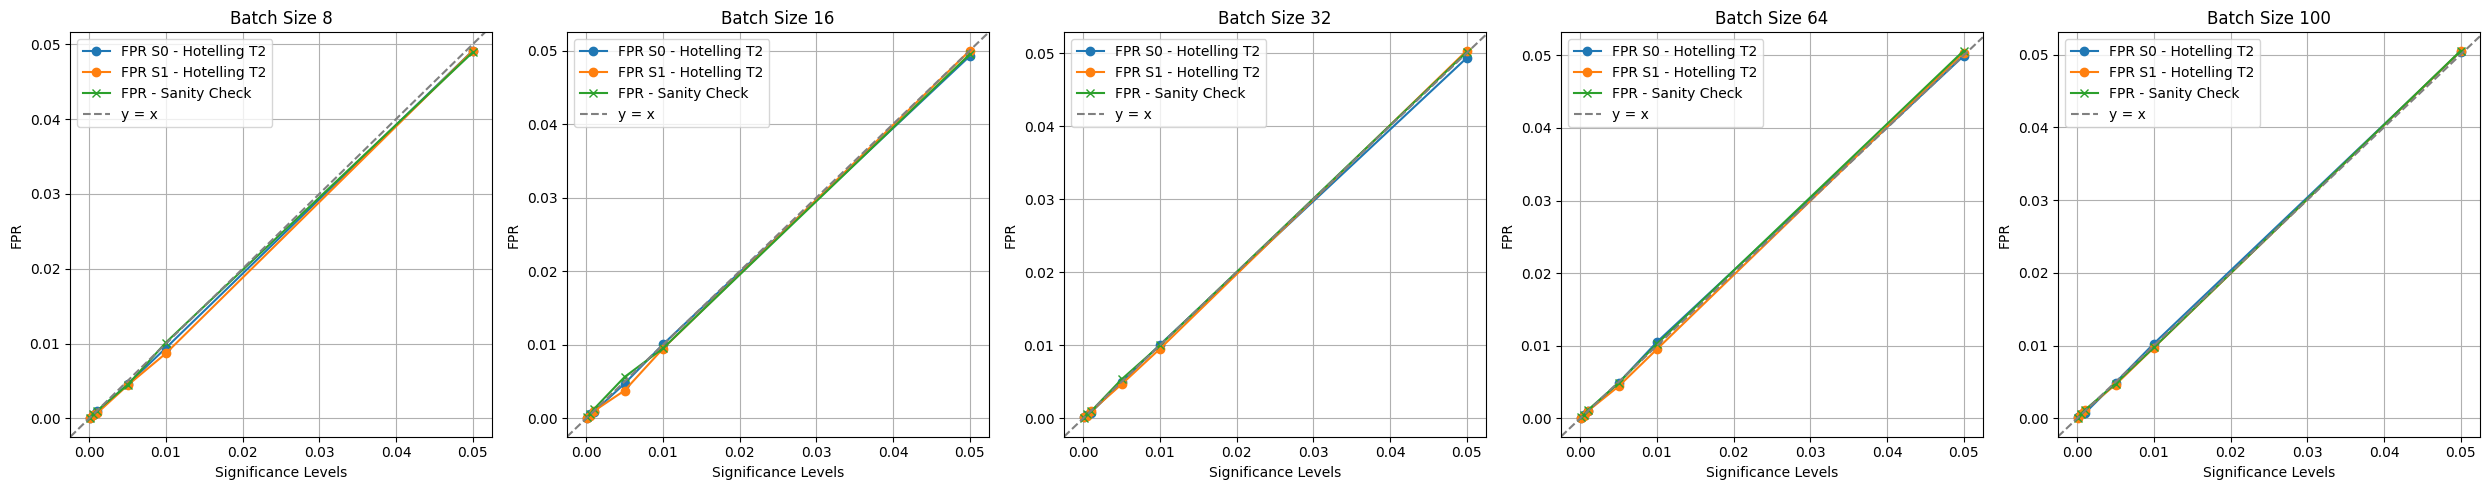

In [60]:
plot_fpr_subplots(df_elicoidale_up)

### Lungomare Canepa

In [61]:
fpr_s0 = calculate_fpr_for_significance_levels(
    aggregated_s0, N, index_segments_k["Lungomare Canepa"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [62]:
fpr_s1 = calculate_fpr_for_significance_levels(
    aggregated_s1, N, index_segments_k["Lungomare Canepa"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [63]:
df_lungomare = transform_fpr_results_2(fpr_gaussian, fpr_s0, fpr_s1, significance_levels)
df_lungomare

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.051218   
1            8              0.0100          0.010137        0.009875   
2            8              0.0050          0.004470        0.005070   
3            8              0.0010          0.001006        0.000820   
4            8              0.0005          0.000568        0.000334   
5            8              0.0001          0.000083        0.000083   
6           16              0.0500          0.049495        0.051633   
7           16              0.0100          0.009509        0.009452   
8           16              0.0050          0.005622        0.004972   
9           16              0.0010          0.001259        0.001039   
10          16              0.0005          0.000552        0.000619   
11          16              0.0001          0.000150        0.000100   
12          32              0.0500          0.050146        0.051338   
13          32              0.0100          0.009986        0.010378   
14          32              0.0050          0.005338        0.004997   
15          32              0.0010          0.000938        0.000854   
16          32              0.0005          0.000619        0.000401   
17          32              0.0001          0.000083        0.000050   
18          64              0.0500          0.050641        0.047727   
19          64              0.0100          0.010253        0.010162   
20          64              0.0050          0.004862        0.004990   
21          64              0.0010          0.001141        0.000854   
22          64              0.0005          0.000485        0.000501   
23          64              0.0001          0.000117        0.000083   
24         100              0.0500          0.050522        0.050721   
25         100              0.0100          0.009749        0.009758   
26         100              0.0050          0.004787        0.005459   
27         100              0.0010          0.001141        0.001107   
28         100              0.0005          0.000636        0.000384   
29         100              0.0001          0.000100        0.000150   

    FPR Scenario 1  
0         0.050528  
1         0.010225  
2         0.005092  
3         0.001157  
4         0.000602  
5         0.000117  
6         0.048260  
7         0.010054  
8         0.004840  
9         0.001141  
10        0.000535  
11        0.000184  
12        0.049961  
13        0.010218  
14        0.005107  
15        0.001089  
16        0.000518  
17        0.000167  
18        0.049565  
19        0.010086  
20        0.005310  
21        0.001073  
22        0.000568  
23        0.000150  
24        0.049455  
25        0.009901  
26        0.004867  
27        0.001056  
28        0.000635  
29        0.000150

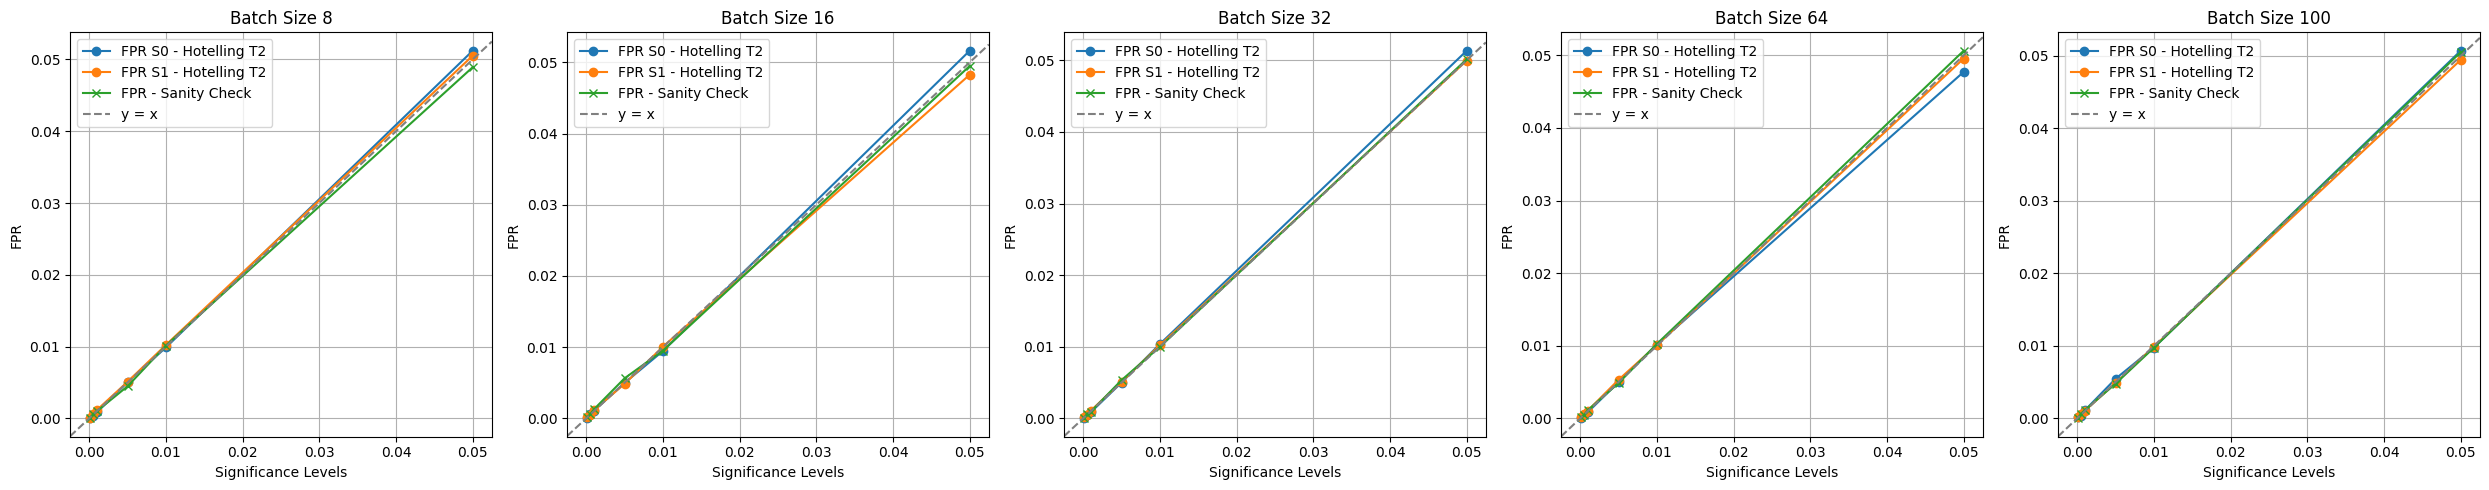

In [64]:
plot_fpr_subplots(df_lungomare)

### Elicoidale Downstream

In [65]:
fpr_s0 = calculate_fpr_for_significance_levels(
    aggregated_s0, N, index_segments_k["Elicoidale Downstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [66]:
fpr_s1 = calculate_fpr_for_significance_levels(
    aggregated_s1, N, index_segments_k["Elicoidale Downstream"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [67]:
df_elicoidale_down = transform_fpr_results_2(fpr_gaussian, fpr_s0, fpr_s1, significance_levels)
df_elicoidale_down

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.048010   
1            8              0.0100          0.010137        0.009326   
2            8              0.0050          0.004470        0.005105   
3            8              0.0010          0.001006        0.001006   
4            8              0.0005          0.000568        0.000501   
5            8              0.0001          0.000083        0.000033   
6           16              0.0500          0.049495        0.050059   
7           16              0.0100          0.009509        0.009807   
8           16              0.0050          0.005622        0.004279   
9           16              0.0010          0.001259        0.000820   
10          16              0.0005          0.000552        0.000384   
11          16              0.0001          0.000150        0.000133   
12          32              0.0500          0.050146        0.050637   
13          32              0.0100          0.009986        0.009278   
14          32              0.0050          0.005338        0.005015   
15          32              0.0010          0.000938        0.000989   
16          32              0.0005          0.000619        0.000568   
17          32              0.0001          0.000083        0.000067   
18          64              0.0500          0.050641        0.048859   
19          64              0.0100          0.010253        0.009867   
20          64              0.0050          0.004862        0.004832   
21          64              0.0010          0.001141        0.001023   
22          64              0.0005          0.000485        0.000535   
23          64              0.0001          0.000117        0.000100   
24         100              0.0500          0.050522        0.050108   
25         100              0.0100          0.009749        0.010017   
26         100              0.0050          0.004787        0.004722   
27         100              0.0010          0.001141        0.000838   
28         100              0.0005          0.000636        0.000384   
29         100              0.0001          0.000100        0.000050   

    FPR Scenario 1  
0         0.050187  
1         0.009593  
2         0.004878  
3         0.001140  
4         0.000552  
5         0.000083  
6         0.047728  
7         0.009962  
8         0.004425  
9         0.000820  
10        0.000468  
11        0.000100  
12        0.048991  
13        0.009976  
14        0.005058  
15        0.000820  
16        0.000418  
17        0.000050  
18        0.049117  
19        0.008752  
20        0.004734  
21        0.000921  
22        0.000418  
23        0.000117  
24        0.048741  
25        0.010074  
26        0.004709  
27        0.000888  
28        0.000501  
29        0.000083

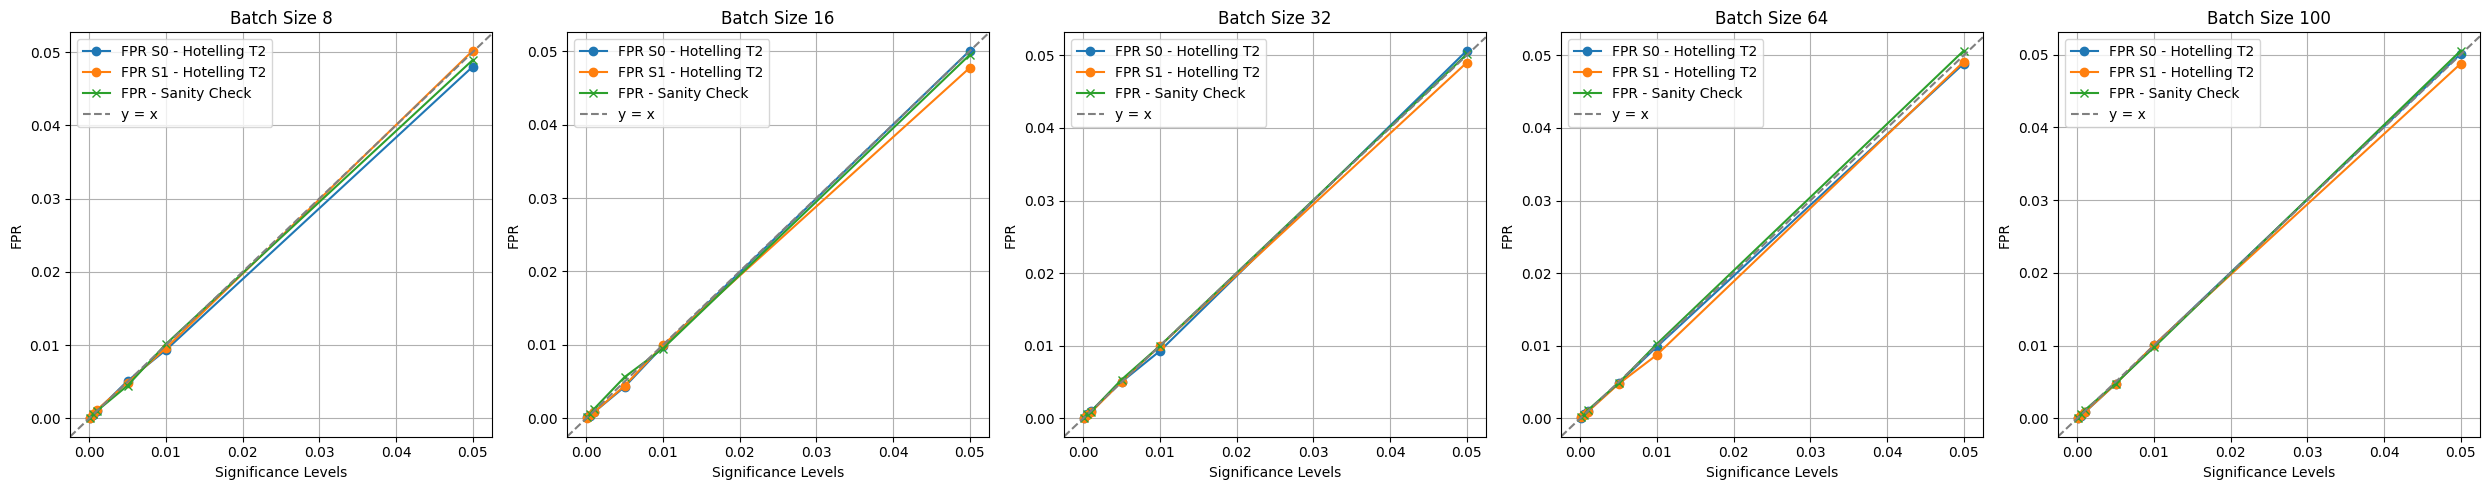

In [68]:
plot_fpr_subplots(df_elicoidale_down)

### Via di Francia

In [69]:
fpr_s0 = calculate_fpr_for_significance_levels(
    aggregated_s0, N, index_segments_k["Via di Francia"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [70]:
fpr_s1 = calculate_fpr_for_significance_levels(
    aggregated_s1, N, index_segments_k["Via di Francia"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [71]:
fpr_gaussian2 = calculate_fpr_for_significance_levels(
    gaussian_data, N, index_segments_k["Via di Francia"], W=1, batch_sizes=batch_sizes, case_function=case1, significance_levels=significance_levels
)

In [72]:
df_francia = transform_fpr_results_2(fpr_gaussian2, fpr_s0, fpr_s1, significance_levels)
df_francia

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048542        0.049079   
1            8              0.0100          0.010108        0.009339   
2            8              0.0050          0.004774        0.004899   
3            8              0.0010          0.000938        0.000820   
4            8              0.0005          0.000485        0.000518   
5            8              0.0001          0.000033        0.000083   
6           16              0.0500          0.049452        0.051418   
7           16              0.0100          0.010178        0.010453   
8           16              0.0050          0.005024        0.005170   
9           16              0.0010          0.000871        0.001089   
10          16              0.0005          0.000569        0.000535   
11          16              0.0001          0.000050        0.000117   
12          32              0.0500          0.048848        0.051838   
13          32              0.0100          0.009804        0.010204   
14          32              0.0050          0.004527        0.005139   
15          32              0.0010          0.001056        0.000988   
16          32              0.0005          0.000468        0.000485   
17          32              0.0001          0.000067        0.000100   
18          64              0.0500          0.049510        0.049431   
19          64              0.0100          0.010194        0.009591   
20          64              0.0050          0.005360        0.004947   
21          64              0.0010          0.000955        0.000905   
22          64              0.0005          0.000652        0.000468   
23          64              0.0001          0.000083        0.000083   
24         100              0.0500          0.050157        0.049695   
25         100              0.0100          0.010063        0.010270   
26         100              0.0050          0.004844        0.004560   
27         100              0.0010          0.001225        0.001107   
28         100              0.0005          0.000451        0.000484   
29         100              0.0001          0.000100        0.000050   

    FPR Scenario 1  
0         0.051464  
1         0.009639  
2         0.004974  
3         0.000938  
4         0.000485  
5         0.000133  
6         0.050461  
7         0.010906  
8         0.005340  
9         0.000853  
10        0.000485  
11        0.000133  
12        0.050281  
13        0.010081  
14        0.005396  
15        0.001191  
16        0.000518  
17        0.000133  
18        0.050667  
19        0.010726  
20        0.005513  
21        0.000904  
22        0.000518  
23        0.000133  
24        0.050199  
25        0.009627  
26        0.004971  
27        0.001056  
28        0.000451  
29        0.000117

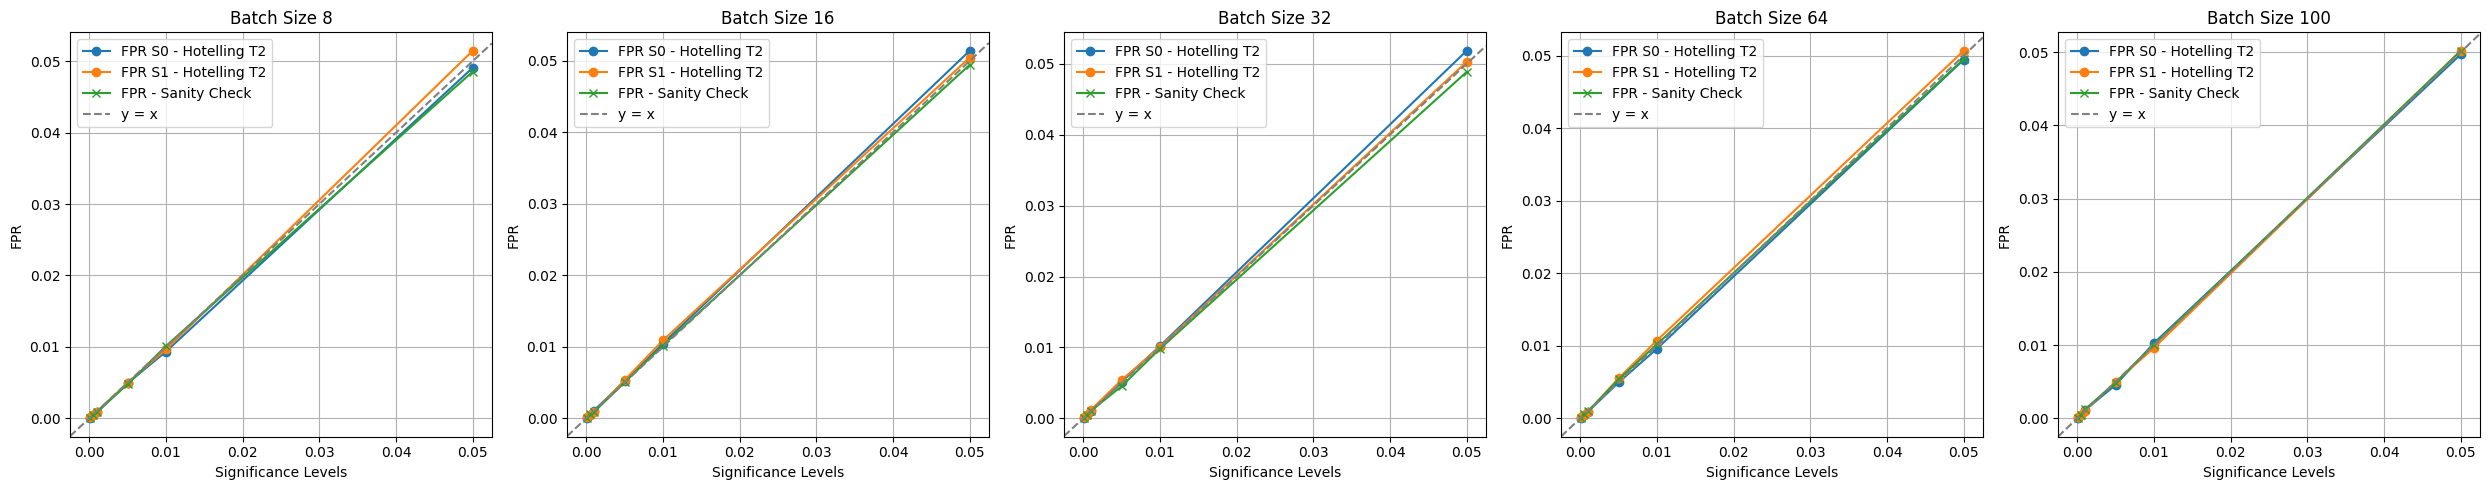

In [73]:
plot_fpr_subplots(df_francia)

### Plot all segments

In [74]:
# prompt: generate a function that given all 4 data frames,  plot per line the subplots of each data frame,. On each line, plot horizontally different subplots per batch size, where it plots FPR Mean and FPR Sanity Check by the significance levels. Make a title per line (the name of the DF)


def plot_all_segments(df_elicoidale_up, df_lungomare, df_elicoidale_down, df_francia):
    """Plots subplots for each dataframe, grouped by batch size."""

    dfs = {
        "Elicoidale Upstream": df_elicoidale_up,
        "Lungomare Canepa": df_lungomare,
        "Elicoidale Downstream": df_elicoidale_down,
        "Via di Francia": df_francia,
    }

    for df_name, df in dfs.items():
        batch_sizes = df['Batch Size'].unique()
        num_plots = len(batch_sizes)
        fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
        fig.suptitle(df_name, fontsize=16) #add title per line

        if num_plots == 1:
            axes = [axes]

        for i, batch_size in enumerate(batch_sizes):
            df_batch = df[df['Batch Size'] == batch_size]
            axes[i].plot(df_batch['Significance Level'], df_batch['FPR Mean'], label='FPR (Scenarios Mean) - Hotelling T2', marker='o')
            axes[i].plot(df_batch['Significance Level'], df_batch['FPR Sanity Check'], label='FPR - Sanity Check', marker='x')
            axes[i].axline((0, 0), slope=1, color='gray', linestyle='--', label="y = x")
            axes[i].set_title(f"Batch Size {batch_size}")
            axes[i].set_xlabel("Significance Levels")
            axes[i].set_ylabel("FPR")
            axes[i].legend()
            axes[i].grid(True)

        plt.tight_layout()
        plt.subplots_adjust(top=0.88) #adjust title position
        plt.show()

In [75]:
#plot_all_segments(df_elicoidale_up, df_lungomare, df_elicoidale_down, df_francia)

#todo

- TPR
- (SANITY CHECK)
- significance_level_values = [0.1, 0.05, 0.01, 0.005, ..., TBD]
- do the test/plot for gaussian
- base line on graph y=x
- add the table

checkin Edoardo (friday, write email with updates to Cristiano and the guys)

- ADD quantree
- plot the results as done for hotelling

checkin again w/ Edoardo (maybe + Boracchi)

In [76]:
def calculate_true_positive_rate(aggregated_data_s0, aggregated_data_s1, N, interesting_k, W, batch_sizes, case_function, significance_level):
    """
    Calculates the true positive rate for a given scenario.

    Args:
        aggregated_data_s0: Aggregated data for scenario 0.
        aggregated_data_s1: Aggregated data for scenario 1.
        N: Number of iterations.
        interesting_k: Index of the interesting segment.
        W: Window size.
        batch_sizes: List of batch sizes to test.
        case_function: The batch generation function (case1, case2, or case3).
        significance_level: The significance level for the Hotelling's T2 test.

    Returns:
        A dictionary where keys are batch sizes and values are the true positive rates.
    """

    true_positive_rates = {}
    for B in batch_sizes:
        true_positives = 0
        total_tests = 0
        for _ in range(N):
            batches_s0 = generate_batches_over_time(
                aggregated_data_s0, batch_size=B, k=interesting_k, W=W, case_function=case_function, case_name="Scenario 0"
            )
            batches_s1 = generate_batches_over_time(
                aggregated_data_s1, batch_size=B, k=interesting_k, W=W, case_function=case_function, case_name="Scenario 1"
            )
            results = calculate_hotelling_between_scenarios(batches_s0, batches_s1)
            for result in results:
                total_tests +=1
                if result["p_value"] < significance_level:
                    true_positives += 1
        true_positive_rates[B] = true_positives / total_tests if total_tests > 0 else 0  # Avoid division by zero
    return true_positive_rates

In [77]:
def calculate_tpr_for_significance_levels(aggregated_data_s0, aggregated_data_s1, N, interesting_k, W, batch_sizes, case_function, significance_levels):
    """
    Calculate the True Positive Rate (TPR) for a range of significance levels.

    Args:
        aggregated_data_s0: Aggregated data for scenario 0.
        aggregated_data_s1: Aggregated data for scenario 1.
        N: Number of iterations.
        interesting_k: Index of the interesting segment.
        W: Window size.
        batch_sizes: List of batch sizes to test.
        case_function: The batch generation function (case1, case2, or case3).
        significance_levels: A range or list of significance levels to evaluate.

    Returns:
        A dictionary where keys are batch sizes and values are lists of TPRs corresponding to the significance levels.
    """
    results = {batch_size: [] for batch_size in batch_sizes}

    for alpha in significance_levels:
        tpr_results = calculate_true_positive_rate(
            aggregated_data_s0, aggregated_data_s1, N, interesting_k, W, batch_sizes, case_function, significance_level=alpha
        )
        for batch_size, tpr in tpr_results.items():
            results[batch_size].append(tpr)

    return results

In [78]:
def calculate_and_append_tpr(df, aggregated_s0, aggregated_s1, segment_name, N, W, batch_sizes, case_function, significance_levels):
    tpr_results = calculate_tpr_for_significance_levels(
        aggregated_s0, aggregated_s1, N, index_segments_k[segment_name], W, batch_sizes, case_function, significance_levels
    )

    # Convert the TPR results into a suitable format to append to the DataFrame
    tpr_data = []
    for batch_size, tprs in tpr_results.items():
      for i, tpr in enumerate(tprs):
          tpr_data.append({
                'Batch Size': batch_size,
                'Significance Level': significance_levels[i],
                'TPR': tpr
            })

    tpr_df = pd.DataFrame(tpr_data)
    # Merge the TPR data with the existing dataframe
    df = pd.merge(df, tpr_df, on=['Batch Size', 'Significance Level'], how='left')
    return df

In [79]:
df_elicoidale_up = calculate_and_append_tpr(
    df_elicoidale_up, aggregated_s0, aggregated_s1, "Elicoidale Upstream", N, 1, batch_sizes, case1, significance_levels
)

In [92]:
df_elicoidale_up

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.049141   
1            8              0.0100          0.010137        0.009406   
2            8              0.0050          0.004470        0.004535   
3            8              0.0010          0.001006        0.000922   
4            8              0.0005          0.000568        0.000384   
5            8              0.0001          0.000083        0.000067   
6           16              0.0500          0.049495        0.049240   
7           16              0.0100          0.009509        0.010048   
8           16              0.0050          0.005622        0.004722   
9           16              0.0010          0.001259        0.000888   
10          16              0.0005          0.000552        0.000619   
11          16              0.0001          0.000150        0.000050   
12          32              0.0500          0.050146        0.049329   
13          32              0.0100          0.009986        0.010086   
14          32              0.0050          0.005338        0.004929   
15          32              0.0010          0.000938        0.000787   
16          32              0.0005          0.000619        0.000468   
17          32              0.0001          0.000083        0.000167   
18          64              0.0500          0.050641        0.049934   
19          64              0.0100          0.010253        0.010507   
20          64              0.0050          0.004862        0.004892   
21          64              0.0010          0.001141        0.001022   
22          64              0.0005          0.000485        0.000451   
23          64              0.0001          0.000117        0.000100   
24         100              0.0500          0.050522        0.050412   
25         100              0.0100          0.009749        0.010277   
26         100              0.0050          0.004787        0.004917   
27         100              0.0010          0.001141        0.000702   
28         100              0.0005          0.000636        0.000535   
29         100              0.0001          0.000100        0.000117   

    FPR Scenario 1       TPR  
0         0.049116  1.000000  
1         0.008686  1.000000  
2         0.004410  0.999883  
3         0.000669  0.995633  
4         0.000501  0.985333  
5         0.000050  0.898433  
6         0.049979  1.000000  
7         0.009471  1.000000  
8         0.003779  1.000000  
9         0.000990  1.000000  
10        0.000367  1.000000  
11        0.000067  1.000000  
12        0.050317  1.000000  
13        0.009516  1.000000  
14        0.004658  1.000000  
15        0.000939  1.000000  
16        0.000367  1.000000  
17        0.000150  1.000000  
18        0.050374  1.000000  
19        0.009518  1.000000  
20        0.004403  1.000000  
21        0.001006  1.000000  
22        0.000351  1.000000  
23        0.000083  1.000000  
24        0.050467  1.000000  
25        0.009716  1.000000  
26        0.004628  1.000000  
27        0.001124  1.000000  
28        0.000602  1.000000  
29        0.000083  1.000000

In [81]:
df_lungomare = calculate_and_append_tpr(
    df_lungomare, aggregated_s0, aggregated_s1, "Lungomare Canepa", N, 1, batch_sizes, case1, significance_levels
)

In [82]:
df_lungomare

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.051218   
1            8              0.0100          0.010137        0.009875   
2            8              0.0050          0.004470        0.005070   
3            8              0.0010          0.001006        0.000820   
4            8              0.0005          0.000568        0.000334   
5            8              0.0001          0.000083        0.000083   
6           16              0.0500          0.049495        0.051633   
7           16              0.0100          0.009509        0.009452   
8           16              0.0050          0.005622        0.004972   
9           16              0.0010          0.001259        0.001039   
10          16              0.0005          0.000552        0.000619   
11          16              0.0001          0.000150        0.000100   
12          32              0.0500          0.050146        0.051338   
13          32              0.0100          0.009986        0.010378   
14          32              0.0050          0.005338        0.004997   
15          32              0.0010          0.000938        0.000854   
16          32              0.0005          0.000619        0.000401   
17          32              0.0001          0.000083        0.000050   
18          64              0.0500          0.050641        0.047727   
19          64              0.0100          0.010253        0.010162   
20          64              0.0050          0.004862        0.004990   
21          64              0.0010          0.001141        0.000854   
22          64              0.0005          0.000485        0.000501   
23          64              0.0001          0.000117        0.000083   
24         100              0.0500          0.050522        0.050721   
25         100              0.0100          0.009749        0.009758   
26         100              0.0050          0.004787        0.005459   
27         100              0.0010          0.001141        0.001107   
28         100              0.0005          0.000636        0.000384   
29         100              0.0001          0.000100        0.000150   

    FPR Scenario 1       TPR  
0         0.050528  1.000000  
1         0.010225  1.000000  
2         0.005092  1.000000  
3         0.001157  1.000000  
4         0.000602  0.999933  
5         0.000117  0.994783  
6         0.048260  1.000000  
7         0.010054  1.000000  
8         0.004840  1.000000  
9         0.001141  1.000000  
10        0.000535  1.000000  
11        0.000184  1.000000  
12        0.049961  1.000000  
13        0.010218  1.000000  
14        0.005107  1.000000  
15        0.001089  1.000000  
16        0.000518  1.000000  
17        0.000167  1.000000  
18        0.049565  1.000000  
19        0.010086  1.000000  
20        0.005310  1.000000  
21        0.001073  1.000000  
22        0.000568  1.000000  
23        0.000150  1.000000  
24        0.049455  1.000000  
25        0.009901  1.000000  
26        0.004867  1.000000  
27        0.001056  1.000000  
28        0.000635  1.000000  
29        0.000150  1.000000

In [83]:
df_elicoidale_down = calculate_and_append_tpr(
    df_elicoidale_down, aggregated_s0, aggregated_s1, "Elicoidale Downstream", N, 1, batch_sizes, case1, significance_levels
)

In [84]:
df_elicoidale_down

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048918        0.048010   
1            8              0.0100          0.010137        0.009326   
2            8              0.0050          0.004470        0.005105   
3            8              0.0010          0.001006        0.001006   
4            8              0.0005          0.000568        0.000501   
5            8              0.0001          0.000083        0.000033   
6           16              0.0500          0.049495        0.050059   
7           16              0.0100          0.009509        0.009807   
8           16              0.0050          0.005622        0.004279   
9           16              0.0010          0.001259        0.000820   
10          16              0.0005          0.000552        0.000384   
11          16              0.0001          0.000150        0.000133   
12          32              0.0500          0.050146        0.050637   
13          32              0.0100          0.009986        0.009278   
14          32              0.0050          0.005338        0.005015   
15          32              0.0010          0.000938        0.000989   
16          32              0.0005          0.000619        0.000568   
17          32              0.0001          0.000083        0.000067   
18          64              0.0500          0.050641        0.048859   
19          64              0.0100          0.010253        0.009867   
20          64              0.0050          0.004862        0.004832   
21          64              0.0010          0.001141        0.001023   
22          64              0.0005          0.000485        0.000535   
23          64              0.0001          0.000117        0.000100   
24         100              0.0500          0.050522        0.050108   
25         100              0.0100          0.009749        0.010017   
26         100              0.0050          0.004787        0.004722   
27         100              0.0010          0.001141        0.000838   
28         100              0.0005          0.000636        0.000384   
29         100              0.0001          0.000100        0.000050   

    FPR Scenario 1       TPR  
0         0.050187  0.999967  
1         0.009593  0.996633  
2         0.004878  0.988133  
3         0.001140  0.923817  
4         0.000552  0.860633  
5         0.000083  0.615267  
6         0.047728  1.000000  
7         0.009962  1.000000  
8         0.004425  1.000000  
9         0.000820  1.000000  
10        0.000468  1.000000  
11        0.000100  1.000000  
12        0.048991  1.000000  
13        0.009976  1.000000  
14        0.005058  1.000000  
15        0.000820  1.000000  
16        0.000418  1.000000  
17        0.000050  1.000000  
18        0.049117  1.000000  
19        0.008752  1.000000  
20        0.004734  1.000000  
21        0.000921  1.000000  
22        0.000418  1.000000  
23        0.000117  1.000000  
24        0.048741  1.000000  
25        0.010074  1.000000  
26        0.004709  1.000000  
27        0.000888  1.000000  
28        0.000501  1.000000  
29        0.000083  1.000000

In [85]:
df_francia = calculate_and_append_tpr(
    df_francia, aggregated_s0, aggregated_s1, "Via di Francia", N, 1, batch_sizes, case1, significance_levels
)

In [86]:
df_francia

Batch Size  Significance Level  FPR Sanity Check  FPR Scenario 0  \
0            8              0.0500          0.048542        0.049079   
1            8              0.0100          0.010108        0.009339   
2            8              0.0050          0.004774        0.004899   
3            8              0.0010          0.000938        0.000820   
4            8              0.0005          0.000485        0.000518   
5            8              0.0001          0.000033        0.000083   
6           16              0.0500          0.049452        0.051418   
7           16              0.0100          0.010178        0.010453   
8           16              0.0050          0.005024        0.005170   
9           16              0.0010          0.000871        0.001089   
10          16              0.0005          0.000569        0.000535   
11          16              0.0001          0.000050        0.000117   
12          32              0.0500          0.048848        0.051838   
13          32              0.0100          0.009804        0.010204   
14          32              0.0050          0.004527        0.005139   
15          32              0.0010          0.001056        0.000988   
16          32              0.0005          0.000468        0.000485   
17          32              0.0001          0.000067        0.000100   
18          64              0.0500          0.049510        0.049431   
19          64              0.0100          0.010194        0.009591   
20          64              0.0050          0.005360        0.004947   
21          64              0.0010          0.000955        0.000905   
22          64              0.0005          0.000652        0.000468   
23          64              0.0001          0.000083        0.000083   
24         100              0.0500          0.050157        0.049695   
25         100              0.0100          0.010063        0.010270   
26         100              0.0050          0.004844        0.004560   
27         100              0.0010          0.001225        0.001107   
28         100              0.0005          0.000451        0.000484   
29         100              0.0001          0.000100        0.000050   

    FPR Scenario 1       TPR  
0         0.051464  1.000000  
1         0.009639  1.000000  
2         0.004974  1.000000  
3         0.000938  1.000000  
4         0.000485  1.000000  
5         0.000133  0.999967  
6         0.050461  1.000000  
7         0.010906  1.000000  
8         0.005340  1.000000  
9         0.000853  1.000000  
10        0.000485  1.000000  
11        0.000133  1.000000  
12        0.050281  1.000000  
13        0.010081  1.000000  
14        0.005396  1.000000  
15        0.001191  1.000000  
16        0.000518  1.000000  
17        0.000133  1.000000  
18        0.050667  1.000000  
19        0.010726  1.000000  
20        0.005513  1.000000  
21        0.000904  1.000000  
22        0.000518  1.000000  
23        0.000133  1.000000  
24        0.050199  1.000000  
25        0.009627  1.000000  
26        0.004971  1.000000  
27        0.001056  1.000000  
28        0.000451  1.000000  
29        0.000117  1.000000

In [89]:
# Define the output path within Colab
output_path = '/content/drive/MyDrive/TESE/data'  # Replace with your desired path

# Create the directory if it doesn't exist
if not os.path.exists(output_path):
    os.makedirs(output_path)


def save_dataframe_to_csv(dataframe, filename, output_path):
  """Saves a dataframe to a CSV file at a specified path.

  Args:
    dataframe: The pandas DataFrame to be saved.
    filename: The name of the output CSV file (without the .csv extension).
    output_path: The directory to save the CSV file to.
  """
  filepath = os.path.join(output_path, f"{filename}.csv")
  dataframe.to_csv(filepath, index=False)
  print(f"Dataframe saved to {filepath}")


# Save each DataFrame to a separate CSV file
save_dataframe_to_csv(df_elicoidale_up, "df_elicoidale_up", output_path)
save_dataframe_to_csv(df_lungomare, "df_lungomare", output_path)
save_dataframe_to_csv(df_elicoidale_down, "df_elicoidale_down", output_path)
save_dataframe_to_csv(df_francia, "df_francia", output_path)

Dataframe saved to /content/drive/MyDrive/TESE/data/df_elicoidale_up.csv
Dataframe saved to /content/drive/MyDrive/TESE/data/df_lungomare.csv
Dataframe saved to /content/drive/MyDrive/TESE/data/df_elicoidale_down.csv
Dataframe saved to /content/drive/MyDrive/TESE/data/df_francia.csv


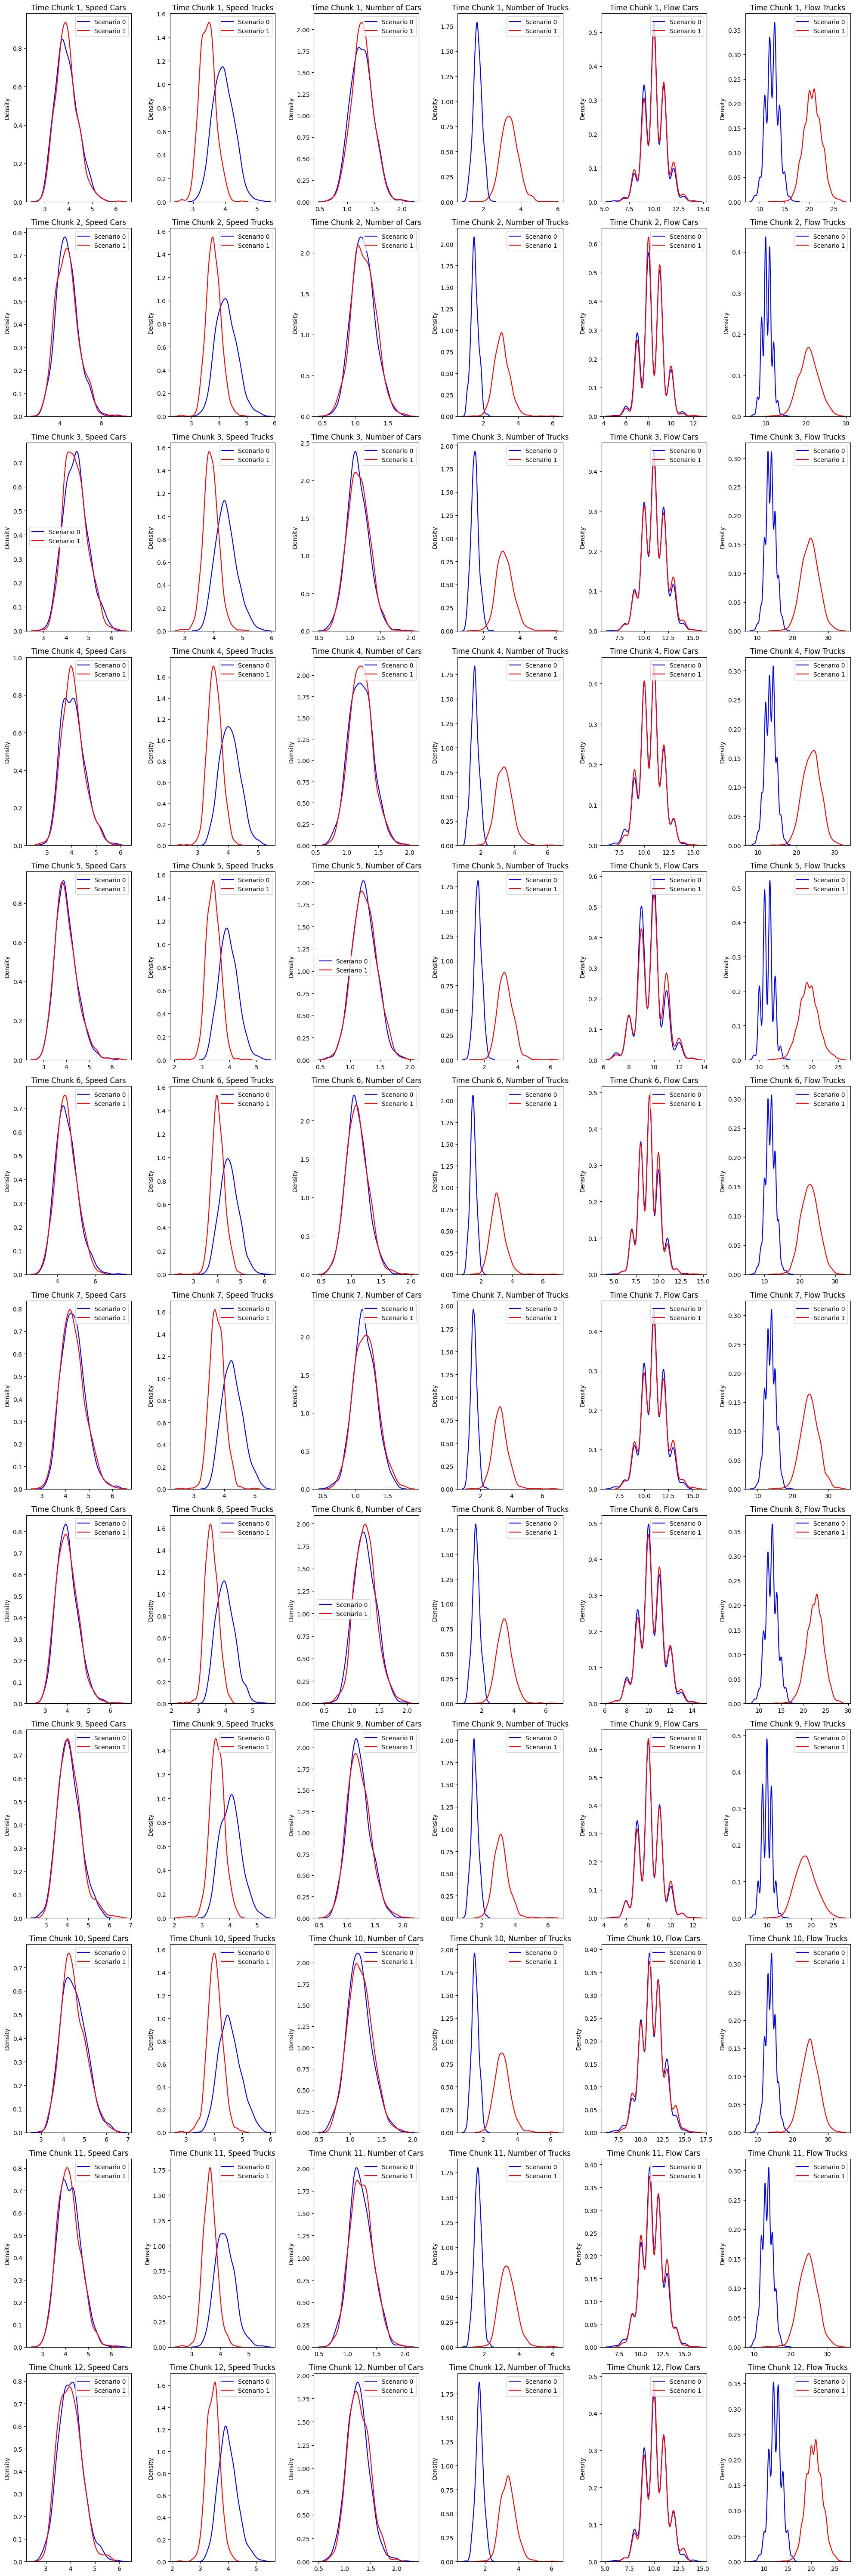

In [91]:
num_variables = len(variable_names)
num_segments = len(interesting_k)
num_timechunks = aggregated_s0.shape[2]

fig, axes = plt.subplots(num_timechunks, num_variables, figsize=(20, 5 * num_timechunks))

for t in range(num_timechunks):
    for v in range(num_variables):
        # Ensure data is 1D
        data_s0_temp = aggregated_s0[v, :, t]
        data_s1_temp = aggregated_s1[v, :, t]

        sns.kdeplot(data=data_s0_temp, ax=axes[t, v], label='Scenario 0', color='blue')
        sns.kdeplot(data=data_s1_temp, ax=axes[t, v], label='Scenario 1', color='red')

        axes[t, v].set_title(f"Time Chunk {t+1}, {variable_names[v]}")
        axes[t, v].legend()

plt.tight_layout()
# Save plot to the output path
output_path = '/content/drive/My Drive/TESE/docs/variable_distribution.png'
plt.savefig(output_path, dpi=300)

plt.show()